In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colormaps
import itertools
import jinja2
import json
import logging
import scipy.stats

from IPython.display import HTML

logging.basicConfig(level=logging.INFO)



In [2]:
### Matplotlib settings

plt.rcParams["font.family"] = "Helvetica"
matplotlib.rc('font', size=11)
plt.ion() # so plots show up immediately 

In [3]:
import value_aggregation as pm
import model_experiment
from shared_analysis import *

# Analysing Data

In [4]:
## Variables
scenario = "maximize=True_num-agents=3_belief-steps=1_belief-range=3,3_action-steps=3\
_action-range=1,101_action-function-log=False_num-scenarios=4_sample-size=68.0"

random_scenario = "maximize=True_num-agents=3_belief-steps=1_belief-range=3,3_action-steps=101\
_action-range=1,101_action-function-log=False_num-scenarios=4_sample-size=68.0"

scenario_file = os.path.join(SCENARIOS_DIR, scenario + ".csv")
random_scenario_file = os.path.join(SCENARIOS_DIR, random_scenario + ".csv")

mturk_condition = "chart_type=area_maximize=True"

model = "gpt-4"
llm_condition = "temp=1_api=chat_qualification=False_show-charts=False_chart-type=area_samples=10_zero-shot=False.csv"

### For getting tcolorbox colors

In [5]:
[x * 256 for x in CONDITION_TO_COLOR['Volume']]

[256.0, 217.85098039215686, 47.1843137254902, 256.0]

In [6]:
[x - .1 for x in CONDITION_TO_COLOR['Volume']]

[0.9, 0.7509803921568627, 0.08431372549019608, 0.9]

### Figure utilities

### Qualificaiton Stats

In [7]:
total_correct = 0
total_size = 0
times = []
for file in os.listdir(MTURK_RESULTS_DIR):
    if not file.startswith('qual_final'):
        continue
    filename = os.path.join(MTURK_RESULTS_DIR, file)
    df = pd.read_csv(filename, na_values=['{}'])
    correct, size = qual_stats(df)
    total_correct += correct
    total_size += size
    times.append(df['Answer.tm'])
print(f'qualification passed {total_correct} / {total_size}, {total_correct / total_size: .2%}')
report_time(times)

qualification passed 659 / 3419,  19.27%
total time in minutes: mean 10.6 and std 7.9 and wage $17.0


### How long did the surveys take to complete?

### Scenario stats

In [8]:
scenario_df = pd.read_csv(scenario_file)
    
scenario_df = explode_df(scenario_df, num_scenarios)

scenario_df = add_fehr(scenario_df, alpha=INEQUALITY_SUPPORT) # this alpha value, as opposed to 1/2, causes fewest disagreements
scenario_df = add_rawls(scenario_df)

print(f"# nash util agree: {len(control(scenario_df)['scenario_hash'].unique())}")
print(f"# nash util disagree: {len(test(scenario_df)['scenario_hash'].unique())}")
print(f"# uncertain (subset of agree): {len(uncertain(scenario_df)['scenario_hash'].unique())}")
print(f"# total: {len(scenario_df['scenario_hash'].unique())}")

print(f"# nash fehr agree: {len(control(scenario_df, between=('scenario_nbs', 'scenario_fehr'))['scenario_hash'].unique())}")
print(f"# nash fehr disagree: {len(test(scenario_df, between=('scenario_nbs', 'scenario_fehr'))['scenario_hash'].unique())}")


print(f"# nash rawls agree: {len(control(scenario_df, between=('scenario_nbs', 'scenario_rawls'))['scenario_hash'].unique())}")
print(f"# nash rawls disagree: {len(test(scenario_df, between=('scenario_nbs', 'scenario_rawls'))['scenario_hash'].unique())}")


# nash util agree: 16
# nash util disagree: 18
# uncertain (subset of agree): 5
# total: 34
# nash fehr agree: 34
# nash fehr disagree: 0
# nash rawls agree: 28
# nash rawls disagree: 6


In [9]:
scenario_df = pd.read_csv(random_scenario_file)
    
scenario_df = explode_df(scenario_df, num_scenarios)
scenario_df = add_fehr(scenario_df, alpha=INEQUALITY_SUPPORT) # this alpha value, as opposed to 1/2, causes fewest disagreements
scenario_df = add_rawls(scenario_df)

print(f"# control: {len(control(scenario_df)['scenario_hash'].unique())}")
print(f"# test: {len(test(scenario_df)['scenario_hash'].unique())}")
print(f"# uncertain (subset of control): {len(uncertain(scenario_df)['scenario_hash'].unique())}")
print(f"# total: {len(scenario_df['scenario_hash'].unique())}")

print(f"# nash fehr agree: {len(control(scenario_df, between=('scenario_nbs', 'scenario_fehr'))['scenario_hash'].unique())}")
print(f"# nash fehr disagree: {len(test(scenario_df, between=('scenario_nbs', 'scenario_fehr'))['scenario_hash'].unique())}")

print(f"# nash rawls agree: {len(control(scenario_df, between=('scenario_nbs', 'scenario_rawls'))['scenario_hash'].unique())}")
print(f"# nash rawls disagree: {len(test(scenario_df, between=('scenario_nbs', 'scenario_rawls'))['scenario_hash'].unique())}")


# control: 16
# test: 18
# uncertain (subset of control): 0
# total: 34
# nash fehr agree: 28
# nash fehr disagree: 6
# nash rawls agree: 22
# nash rawls disagree: 12


### Preprocessing

### Size stats

Area: 0/0.00 failed checks out of 102
Both: 0/0.00 failed checks out of 102
None: 0/0.00 failed checks out of 102
Volume: 0/0.00 failed checks out of 102
Total workers failed checks: 0
total time in minutes: mean 6.1 and std 3.9 and wage $29.4

claude-3-opus-20240229
temp=1_api=chat_qualification=False_show-charts=False_chart-type=area_samples=10_zero-shot=False.csv
0/0.00 total: 136
claude-3-opus-20240229
temp=1_api=chat_qualification=True_show-charts=False_chart-type=volume_samples=10_zero-shot=False.csv
0/0.00 total: 136
claude-3-opus-20240229
temp=1_api=chat_qualification=False_show-charts=True_chart-type=area_samples=10_zero-shot=False.csv
3/0.02 total: 136
claude-3-opus-20240229
temp=1_api=chat_qualification=True_show-charts=False_chart-type=area_samples=10_zero-shot=False.csv
0/0.00 total: 136
claude-3-opus-20240229
temp=1_api=chat_qualification=False_show-charts=True_chart-type=volume_samples=10_zero-shot=False.csv
1/0.01 total: 136
claude-3-opus-20240229
temp=1_api=chat_qualif

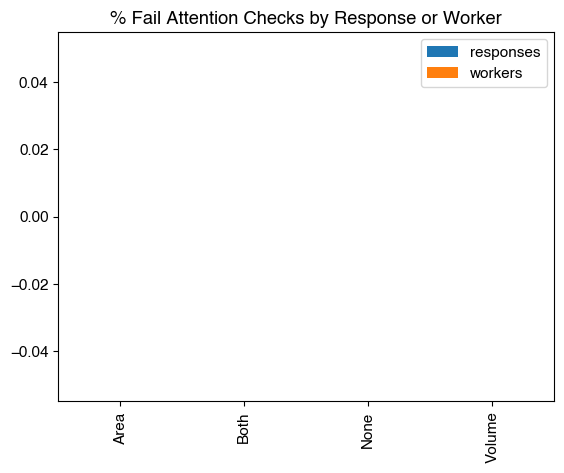

In [10]:
mturk_dfs(scenario, num_scenarios)
print()
llm_dfs(scenario, print_size=True)
pass

## How good are the LLMs at the qualificaiton task?

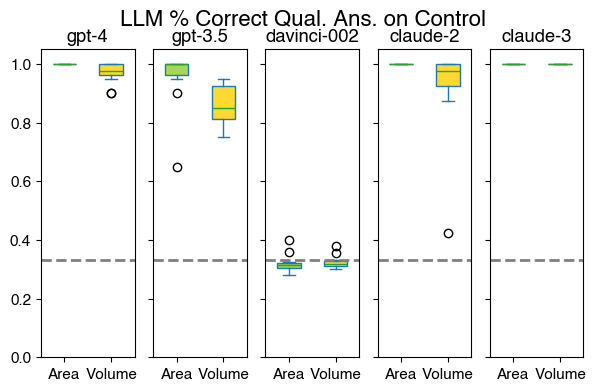

In [11]:
llm_qual_area_chat = "temp=1_api=chat_qualification=True_show-charts=False_chart-type=area_samples=10_zero-shot=False.csv"
llm_qual_area_comp = "temp=1_api=completion_qualification=True_show-charts=False_chart-type=area_samples=10_zero-shot=False.csv"

llm_qual_vol_chat = "temp=1_api=chat_qualification=True_show-charts=False_chart-type=volume_samples=10_zero-shot=False.csv"
llm_qual_vol_comp = "temp=1_api=completion_qualification=True_show-charts=False_chart-type=volume_samples=10_zero-shot=False.csv"

llm_qual_none_comp = "temp=1_api=completion_qualification=True_show-charts=False_chart-type=area_samples=10_zero-shot=False.csv"
llm_qual_none_chat = "temp=1_api=chat_qualification=True_show-charts=False_chart-type=area_samples=10_zero-shot=False.csv"

llm_qual_both_comp = "temp=1_api=completion_qualification=True_show-charts=False_chart-type=both_samples=10_zero-shot=False.csv"
llm_qual_both_chat = "temp=1_api=chat_qualification=True_show-charts=False_chart-type=both_samples=10_zero-shot=False.csv"


dfs_area = llm_dfs(scenario, desired_condition=llm_qual_area_chat)
dfs_area += llm_dfs(scenario, desired_condition=llm_qual_area_comp)
dfs_volume = llm_dfs(scenario, desired_condition=llm_qual_vol_chat)
dfs_volume += llm_dfs(scenario, desired_condition=llm_qual_vol_comp)

result = {}

for model in MODELS:
    result[model] = []

for df in dfs_area:
    right_answer = not_null_ties(control(df)).apply(get_mec_percent, axis=1)
    right_answer.name = "Area"
    result[df.name].append(right_answer.to_frame())

for df in dfs_volume:
    right_answer = not_null_ties(control(df)).apply(get_mec_percent, axis=1)
    right_answer.name = "Volume"
    result[df.name].append(right_answer.to_frame())

# The responses of each model for each condition of 'area' and "volume" should be the same
results = []
fig, ax = plt.subplots(ncols=5, sharey=True, figsize=(7, 4))
fig.suptitle('LLM % Correct Qual. Ans. on Control', fontsize=16)
for i in range(len(MODELS)):
    model = MODELS[i]
    res = pd.concat(result[model])

    _, bplot = res.plot.box(title=model, ax=ax[i], widths=.5, patch_artist=True, return_type='both')
    for patch, color in zip(bplot['boxes'], list(CONDITION_TO_COLOR.values())[:2]):
        patch.set_facecolor(color)
    ax[i].set_ylim(0, 1.05)
    plot_random(ax[i])

plt.savefig("figures/llm_qual_control.pdf", bbox_inches='tight')
plt.show()


## example generations

In [12]:
desired_json_ex = 'W3sidXRpbGl0eSI6IDUxLjAsICJhZ2VudCI6ICJhcHBsZS3wn42OIiwgImNyZWRlbmNlIjogMzMuMCwgImFjdGlvbiI6ICJvbmUifSwgeyJ1dGlsaXR5IjogMS4wLCAiYWdlbnQiOiAiYmVlLfCfkJ0iLCAiY3JlZGVuY2UiOiAzMy4wLCAiYWN0aW9uIjogIm9uZSJ9LCB7InV0aWxpdHkiOiAxLjAsICJhZ2VudCI6ICJjb3ct8J+QriIsICJjcmVkZW5jZSI6IDMzLjAsICJhY3Rpb24iOiAib25lIn0sIHsidXRpbGl0eSI6IDEuMCwgImFnZW50IjogImFwcGxlLfCfjY4iLCAiY3JlZGVuY2UiOiAzMy4wLCAiYWN0aW9uIjogInR3byJ9LCB7InV0aWxpdHkiOiAxMDEuMCwgImFnZW50IjogImJlZS3wn5CdIiwgImNyZWRlbmNlIjogMzMuMCwgImFjdGlvbiI6ICJ0d28ifSwgeyJ1dGlsaXR5IjogMTAxLjAsICJhZ2VudCI6ICJjb3ct8J+QriIsICJjcmVkZW5jZSI6IDMzLjAsICJhY3Rpb24iOiAidHdvIn0sIHsidXRpbGl0eSI6IDUxLjAsICJhZ2VudCI6ICJhcHBsZS3wn42OIiwgImNyZWRlbmNlIjogMzMuMCwgImFjdGlvbiI6ICJ0aHJlZSJ9LCB7InV0aWxpdHkiOiA1MS4wLCAiYWdlbnQiOiAiYmVlLfCfkJ0iLCAiY3JlZGVuY2UiOiAzMy4wLCAiYWN0aW9uIjogInRocmVlIn0sIHsidXRpbGl0eSI6IDUxLjAsICJhZ2VudCI6ICJjb3ct8J+QriIsICJjcmVkZW5jZSI6IDMzLjAsICJhY3Rpb24iOiAidGhyZWUifV0='

# this one we had been using because it has a more clear cuboid but the sum/product tradeoff is not as clear

desired_json = "W3sidXRpbGl0eSI6IDEwMS4wLCAiYWdlbnQiOiAiYXBwbGUt8J+NjiIsICJjcmVkZW5jZSI6IDMzLjAsICJhY3Rpb24iOiAib25lIn0sIHsidXRpbGl0eSI6IDEuMCwgImFnZW50IjogImJlZS3wn5CdIiwgImNyZWRlbmNlIjogMzMuMCwgImFjdGlvbiI6ICJvbmUifSwgeyJ1dGlsaXR5IjogMS4wLCAiYWdlbnQiOiAiY293LfCfkK4iLCAiY3JlZGVuY2UiOiAzMy4wLCAiYWN0aW9uIjogIm9uZSJ9LCB7InV0aWxpdHkiOiAxLjAsICJhZ2VudCI6ICJhcHBsZS3wn42OIiwgImNyZWRlbmNlIjogMzMuMCwgImFjdGlvbiI6ICJ0d28ifSwgeyJ1dGlsaXR5IjogNTEuMCwgImFnZW50IjogImJlZS3wn5CdIiwgImNyZWRlbmNlIjogMzMuMCwgImFjdGlvbiI6ICJ0d28ifSwgeyJ1dGlsaXR5IjogNTEuMCwgImFnZW50IjogImNvdy3wn5CuIiwgImNyZWRlbmNlIjogMzMuMCwgImFjdGlvbiI6ICJ0d28ifSwgeyJ1dGlsaXR5IjogMS4wLCAiYWdlbnQiOiAiYXBwbGUt8J+NjiIsICJjcmVkZW5jZSI6IDMzLjAsICJhY3Rpb24iOiAidGhyZWUifSwgeyJ1dGlsaXR5IjogNTEuMCwgImFnZW50IjogImJlZS3wn5CdIiwgImNyZWRlbmNlIjogMzMuMCwgImFjdGlvbiI6ICJ0aHJlZSJ9LCB7InV0aWxpdHkiOiAxLjAsICJhZ2VudCI6ICJjb3ct8J+QriIsICJjcmVkZW5jZSI6IDMzLjAsICJhY3Rpb24iOiAidGhyZWUifV0="

desired_json_from_graph = "W3sidXRpbGl0eSI6IDEuMCwgImFnZW50IjogImFwcGxlLfCfjY4iLCAiY3JlZGVuY2UiOiAzMy4wLCAiYWN0aW9uIjogIm9uZSJ9LCB7InV0aWxpdHkiOiA1MS4wLCAiYWdlbnQiOiAiYmVlLfCfkJ0iLCAiY3JlZGVuY2UiOiAzMy4wLCAiYWN0aW9uIjogIm9uZSJ9LCB7InV0aWxpdHkiOiA1MS4wLCAiYWdlbnQiOiAiY293LfCfkK4iLCAiY3JlZGVuY2UiOiAzMy4wLCAiYWN0aW9uIjogIm9uZSJ9LCB7InV0aWxpdHkiOiAxLjAsICJhZ2VudCI6ICJhcHBsZS3wn42OIiwgImNyZWRlbmNlIjogMzMuMCwgImFjdGlvbiI6ICJ0d28ifSwgeyJ1dGlsaXR5IjogNTEuMCwgImFnZW50IjogImJlZS3wn5CdIiwgImNyZWRlbmNlIjogMzMuMCwgImFjdGlvbiI6ICJ0d28ifSwgeyJ1dGlsaXR5IjogMS4wLCAiYWdlbnQiOiAiY293LfCfkK4iLCAiY3JlZGVuY2UiOiAzMy4wLCAiYWN0aW9uIjogInR3byJ9LCB7InV0aWxpdHkiOiAxMDEuMCwgImFnZW50IjogImFwcGxlLfCfjY4iLCAiY3JlZGVuY2UiOiAzMy4wLCAiYWN0aW9uIjogInRocmVlIn0sIHsidXRpbGl0eSI6IDEuMCwgImFnZW50IjogImJlZS3wn5CdIiwgImNyZWRlbmNlIjogMzMuMCwgImFjdGlvbiI6ICJ0aHJlZSJ9LCB7InV0aWxpdHkiOiAxLjAsICJhZ2VudCI6ICJjb3ct8J+QriIsICJjcmVkZW5jZSI6IDMzLjAsICJhY3Rpb24iOiAidGhyZWUifV0="

# this one does not actually appear in the generations; possibly it was from an old generation

In [13]:
desired_json_ex == desired_json_from_graph

False

In [14]:
claude_area_qual = llm_dfs(scenario, qualification=True, aggregate_responses=False, desired_condition='area', desired_model='claude-2')[0]
claude_volume_qual = llm_dfs(scenario, qualification=True, aggregate_responses=False, desired_condition='volume', desired_model='claude-2')[0]
claude_ex_qual_volume = claude_volume_qual[claude_volume_qual['scenario_json'] == desired_json].iloc[0]
claude_ex_qual_area = claude_area_qual[claude_area_qual['scenario_json'] == desired_json].iloc[0]

claude_area = llm_dfs(scenario, qualification=False, aggregate_responses=False, desired_condition='show-charts=True_chart-type=area', desired_model='claude-2')[0]
claude_volume = llm_dfs(scenario, qualification=False, aggregate_responses=False, desired_condition='volume', desired_model='claude-2')[0]
claude_ex_volume = claude_volume[claude_volume['scenario_json'] == desired_json].iloc[0]
claude_ex_area = claude_area[claude_area['scenario_json'] == desired_json].iloc[0]

In [15]:
# NB: The qualificaiton task for the models is not the same exact one as for people. Rather
# We give them the qualification questions and answers and then test how well they can calculate NBS, MEC on each of the items
# in the scenario

In [16]:
print(claude_ex_area['full'])



Human: Follow the given examples and answer the questions. Give exactly one answer.

Human: In this scenario, there are 2 groups:
- group A with 10 people in it, and 
- group B with 10 people in it.

There is 1 proposal:
- proposal one: with an outcome of 20 for group A, and 10 for group B.

Which of the proposal(s) takes up the largest total volume?
- (A) Proposal one

Assistant: Let's think step by step. The total volume for a proposal is calculated by multiplying the proposed outcome raised to the (normalized) group size for each group.

For proposal one, the total volume is 20 ** 0.5 (for group "A") + 10 ** 0.5 (for group "B") = 4.47213595499958 * 3.1622776601683795 = 14.1.

Therefore, for the question of which proposal takes up the largest volume area, the answer is (A) Proposal one.

Human: Summarize your answer to the question above by writing only the proposal letter.

Assistant: A

Human: In this scenario, there are 2 groups:
- group A with 10 people in it, and 
- group B wi

In [17]:
print(claude_ex_volume['full'])



Human: Follow the given examples and answer the questions. Give exactly one answer.

Human: In this scenario, there are 2 groups:
- group A with 10 people in it, and 
- group B with 10 people in it.

There is 1 proposal:
- proposal one: with an outcome of 20 for group A, and 10 for group B.

Which of the proposal(s) takes up the largest total volume?
- (A) Proposal one

Assistant: Let's think step by step. The total volume for a proposal is calculated by multiplying the proposed outcome raised to the (normalized) group size for each group.

For proposal one, the total volume is 20 ** 0.5 (for group "A") + 10 ** 0.5 (for group "B") = 4.5 * 3.2 = 14.1.

Therefore, for the question of which proposal takes up the largest volume area, the answer is (A) Proposal one.

Human: Summarize your answer to the question above by writing only the proposal letter.

Assistant: A

Human: In this scenario, there are 2 groups:
- group A with 10 people in it, and 
- group B with 10 people in it.

There i

In [18]:
print(claude_ex_qual_area['full'])



Human: Follow the given examples and answer the questions. Give exactly one answer.

Human: In this scenario, there are 2 groups:
- group A with 10 people in it, and 
- group B with 10 people in it.

There is 1 proposal:
- proposal one: with an outcome of 20 for group A, and 10 for group B.

Which of the proposal(s) takes up the largest total volume?
- (A) Proposal one

Assistant: Let's think step by step. The total volume for a proposal is calculated by multiplying the proposed outcome raised to the (normalized) group size for each group.

For proposal one, the total volume is 20 ** 0.5 (for group "A") + 10 ** 0.5 (for group "B") = 4.47213595499958 * 3.1622776601683795 = 14.1.

Therefore, for the question of which proposal takes up the largest volume area, the answer is (A) Proposal one.

Human: Summarize your answer to the question above by writing only the proposal letter.

Assistant: A

Human: In this scenario, there are 2 groups:
- group A with 10 people in it, and 
- group B wi

In [19]:
print(claude_ex_qual_volume['full'])



Human: Follow the given examples and answer the questions. Give exactly one answer.

Human: In this scenario, there are 2 groups:
- group A with 10 people in it, and 
- group B with 10 people in it.

There is 1 proposal:
- proposal one: with an outcome of 20 for group A, and 10 for group B.

Which of the proposal(s) takes up the largest total volume?
- (A) Proposal one

Assistant: Let's think step by step. The total volume for a proposal is calculated by multiplying the proposed outcome raised to the (normalized) group size for each group.

For proposal one, the total volume is 20 ** 0.5 (for group "A") + 10 ** 0.5 (for group "B") = 4.5 * 3.2 = 14.1.

Therefore, for the question of which proposal takes up the largest volume area, the answer is (A) Proposal one.

Human: Summarize your answer to the question above by writing only the proposal letter.

Assistant: A

Human: In this scenario, there are 2 groups:
- group A with 10 people in it, and 
- group B with 10 people in it.

There i

In [20]:
claude_area = llm_dfs(scenario, qualification=False, aggregate_responses=False, desired_condition='area', desired_model='claude-2')[1]
claude_volume = llm_dfs(scenario, qualification=False, aggregate_responses=False, desired_condition='volume', desired_model='claude-2')[0]
claude_ex_volume = claude_volume[claude_volume['scenario_json'] == desired_json_ex]
claude_ex_area = claude_area[claude_area['scenario_json'] == desired_json_ex]

### Control Analysis

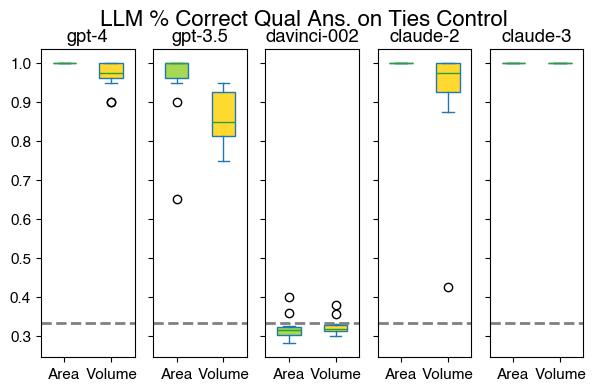

In [25]:
# This doesn't really look different than the last

result = {}

for model in MODELS:
    result[model] = []

for df in dfs_area:
    right_answer = control(not_null_ties(df)).apply(get_mec_percent, axis=1)
    right_answer.name = "Area"
    result[df.name].append(right_answer.to_frame())
    
for df in dfs_volume:
    right_answer = control(not_null_ties(df)).apply(get_nbs_percent, axis=1)
    right_answer.name = "Volume"
    result[df.name].append(right_answer.to_frame())
    
fig, ax = plt.subplots(ncols=5, sharey=True, figsize=(7, 4))
fig.suptitle('LLM % Correct Qual Ans. on Ties Control', fontsize=16)
for i in range(len(MODELS)):
    model = MODELS[i]
    res = pd.concat(result[model])
    _, bplot = res.plot.box(title=model, ax=ax[i], widths=.5, patch_artist=True, return_type='both')
    for patch, color in zip(bplot['boxes'], list(CONDITION_TO_COLOR.values())[:2]):
        patch.set_facecolor(color)
    plot_random(ax[i])

In [26]:
# same issue as above
gpt4_dfs_qual = llm_dfs(scenario, desired_model='gpt4', desired_condition=llm_qual_area_chat)
gpt4_dfs_qual += llm_dfs(scenario, desired_model='gpt4', desired_condition=llm_qual_none_chat)
gpt4_dfs_qual += llm_dfs(scenario, desired_model='gpt4', desired_condition=llm_qual_none_chat)
# percent_correct_area_by_condition(dfs_area, "area")

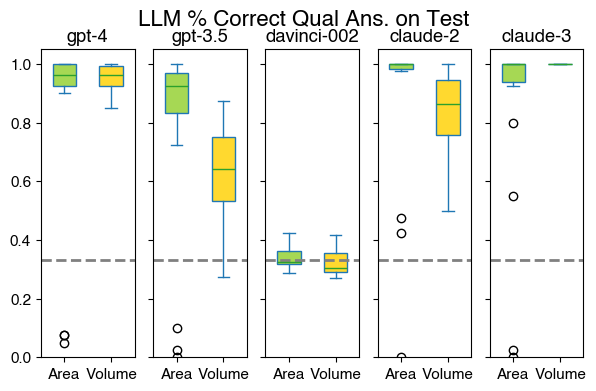

In [30]:

result = {}

for model in MODELS:
    result[model] = []

for df in dfs_area:
    right_answer = test(df).apply(get_mec_percent, axis=1)
    right_answer.name = "Area"
    result[df.name].append(right_answer.to_frame())
    
for df in dfs_volume:
    right_answer = test(df).apply(get_nbs_percent, axis=1)
    right_answer.name = "Volume"
    result[df.name].append(right_answer.to_frame())
    
fig, ax = plt.subplots(ncols=5, sharey=True, figsize=(7,4))
fig.suptitle('LLM % Correct Qual Ans. on Test', fontsize=16)
for i in range(len(MODELS)):
    model = MODELS[i]
    res = pd.concat(result[model])
    _, bplot = res.plot.box(title=model, ax=ax[i], widths=.5, return_type='both', patch_artist=True)
    for patch, color in zip(bplot['boxes'], list(CONDITION_TO_COLOR.values())[:2]):
        patch.set_facecolor(color)
    ax[i].set_ylim(0, 1.05)        
    plot_random(ax[i])

plt.savefig("figures/llm_qual_test.pdf", bbox_inches='tight')
plt.savefig("figures/llm_qual_test.svg", bbox_inches='tight', transparent=True)
plt.show()
# we would expect to see high agreement for both of these conditions and low agreement for the reversed

## Main plotting functions

# How often are they correct for control?

In [31]:
models_to_dfs, models_to_dfs_no_agg = get_all_llm_dfs(scenario)

In [32]:
random_models_to_dfs, random_models_to_dfs_no_agg = get_all_llm_dfs(random_scenario)

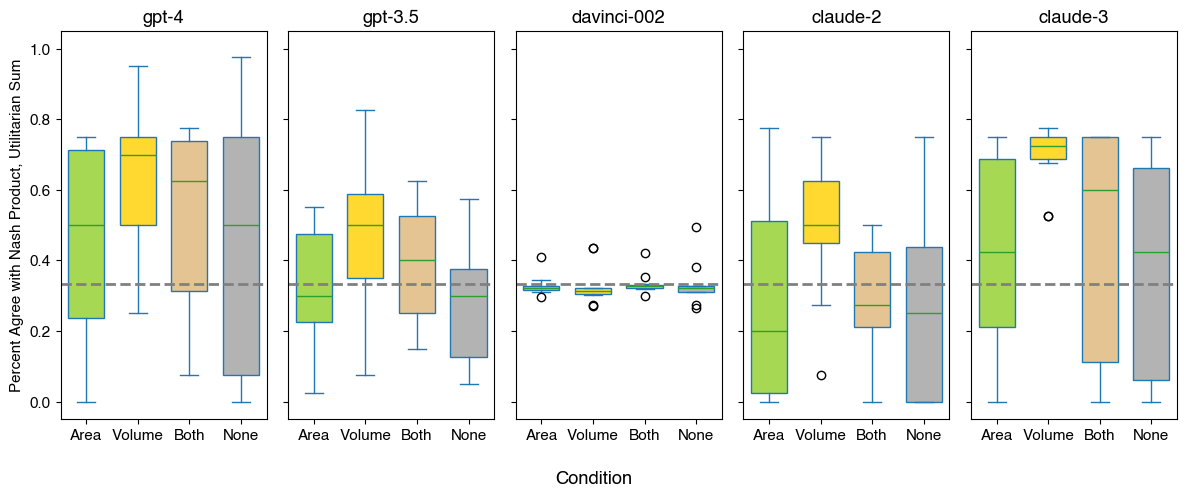

In [34]:
result = {}

for model in models_to_dfs:
    for df in models_to_dfs[model]:
        right_answer = control(df).apply(get_mec_percent, axis=1)
        right_answer.name = df.name
        if model not in result:
            result[model] = []
        result[model].append(right_answer.to_frame())

fig, ax = plt.subplots(ncols=5, sharey=True, figsize=(12 , 5))
# fig.suptitle('LLM % Correct Answer on Control', fontsize=16)
for i in range(len(MODELS)):
    model = MODELS[i]
    res = pd.concat(result[model])
    _, bplot = res.plot.box(title=model, ax=ax[i], widths=BOX_PLOT_WIDTH,
                            ylim=PERCENT_PLT_YLIM, ylabel=f"Percent Agree with {nbs_long}, {mec_long}", 
                            patch_artist=True, return_type='both')
    for patch, color in zip(bplot['boxes'], list(CONDITION_TO_COLOR.values())):
        patch.set_facecolor(color)
    plot_random(ax[i])
fig.supxlabel('Condition')
plt.tight_layout()
plt.savefig("figures/llm_control_means.pdf", bbox_inches='tight')
plt.savefig("figures/llm_control_means.svg", bbox_inches='tight', transparent=True)
plt.tight_layout()
plt.show()

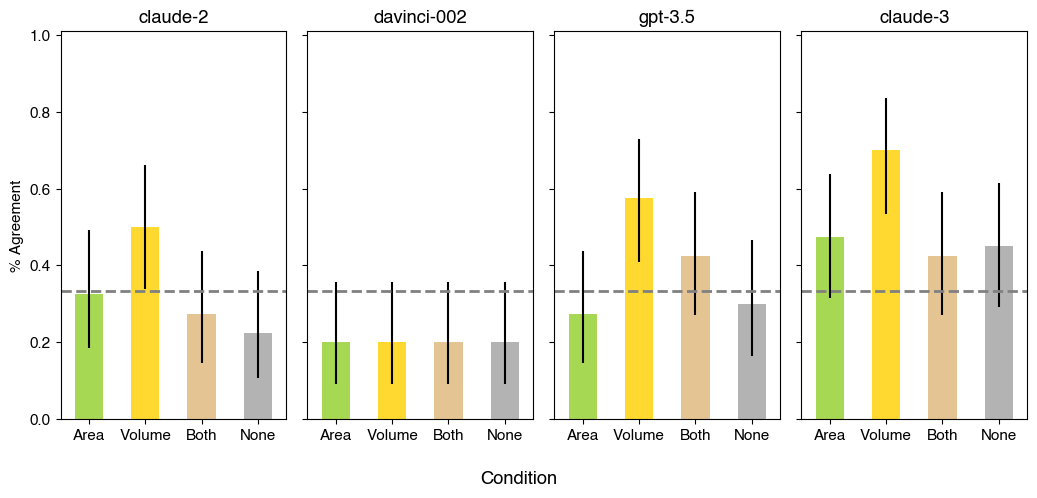

In [35]:
fig, ax = plt.subplots(ncols=4, sharey=True, figsize=(((LLM_TEST_PLOT_WIDTH * len(CONDITION_ORDER)) / 2 + .2) * len(MODELS) , 5))
for i, model in enumerate(set(MODELS) - set(['gpt-4'])):
    dfs = list(models_to_dfs_no_agg.values())
    plot_control_binomial(models_to_dfs_no_agg[model], title=model, ax=ax[i])
fig.supxlabel('Condition')

save_fig(fig, 'llm_control')

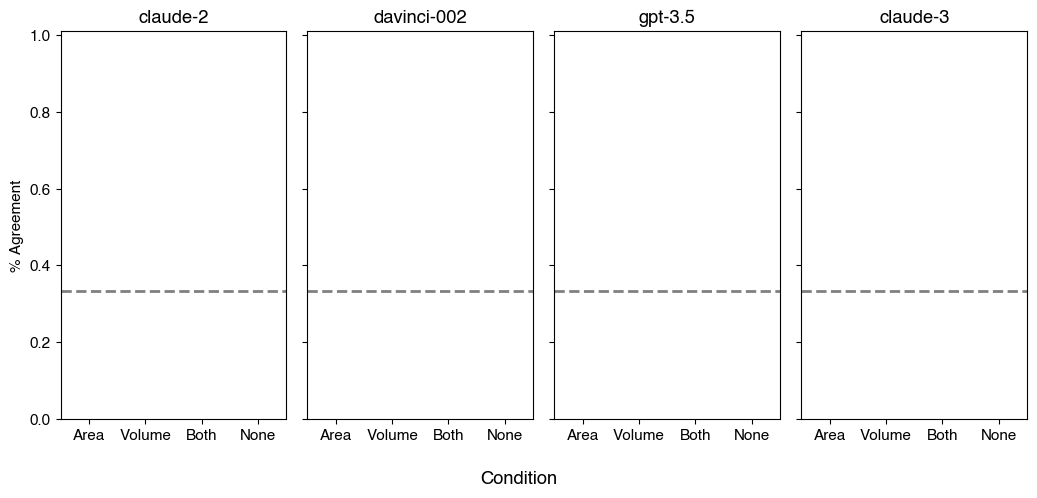

In [37]:
fig, ax = plt.subplots(ncols=4, sharey=True, figsize=(((LLM_TEST_PLOT_WIDTH * len(CONDITION_ORDER)) / 2 + .2) * len(MODELS) , 5))
for i, model in enumerate(set(MODELS) - set(['gpt-4'])):
    dfs = list(models_to_dfs_no_agg.values())
    plot_control_binomial(models_to_dfs_no_agg[model], title=model, ax=ax[i], blank=True)
fig.supxlabel('Condition')

save_fig(fig, 'llm_control_blank')

<Axes: title={'center': 'gpt-4'}, ylabel='% Agreement'>

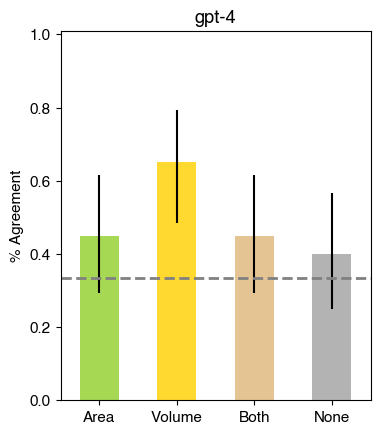

In [38]:
model = 'gpt-4'

dfs = list(models_to_dfs_no_agg.values())
dfs = models_to_dfs_no_agg[model]

fig, ax = plt.subplots(ncols=1, sharey=True, figsize=(1 + ((3 / 4) * len(dfs)),4.8))

plot_control_binomial(dfs, title=model, ax=ax)

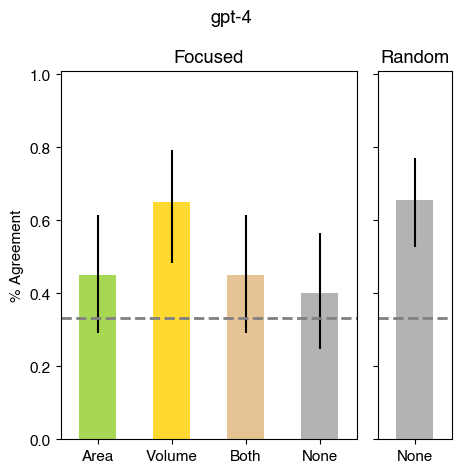

In [39]:
model = 'gpt-4'

dfs = list(models_to_dfs_no_agg.values())
dfs = models_to_dfs_no_agg[model]

num = 5
fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(1 + ((3 / 4) * num),4.8), width_ratios=[4, 1], squeeze=True)

fig.suptitle(model)

plot_control_binomial(dfs, title='Focused', ax=ax[0])


dfs = list(random_models_to_dfs_no_agg.values())
dfs = random_models_to_dfs_no_agg[model]
dfs = list(filter(lambda x: x.name == 'None', dfs))

plot_control_binomial(dfs, title='Random', ax=ax[1])

save_fig(fig, 'gpt-4_control')

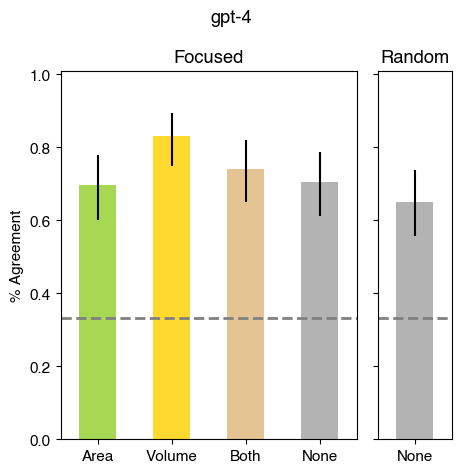

In [40]:
model = 'gpt-4'

dfs = list(models_to_dfs_no_agg.values())
dfs = models_to_dfs_no_agg[model]

num = 5
fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(1 + ((3 / 4) * num),4.8), width_ratios=[4, 1], squeeze=True)

fig.suptitle(model)

plot_control_binomial(dfs, title='Focused', ax=ax[0], between=('scenario_nbs', 'scenario_fehr'))


dfs = list(random_models_to_dfs_no_agg.values())
dfs = random_models_to_dfs_no_agg[model]
dfs = list(filter(lambda x: x.name == 'None', dfs))

plot_control_binomial(dfs, title='Random', ax=ax[1], between=('scenario_nbs', 'scenario_fehr'))

save_fig(fig, 'gpt-4_control_fehr_nash')

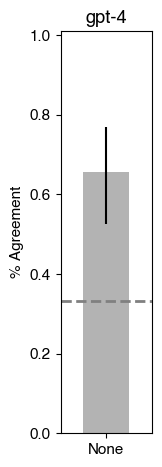

In [41]:
model = 'gpt-4'

dfs = list(random_models_to_dfs_no_agg.values())
dfs = random_models_to_dfs_no_agg[model]
dfs = list(filter(lambda x: x.name == 'None', dfs))

fig, ax = plt.subplots(ncols=1, sharey=True, figsize=(1 + ((3 / 4) * len(dfs)),4.8))
ax.set_xlabel('')

plot_control_binomial(dfs, title=model, ax=ax)

save_fig(fig, 'gpt-4_random_control_none')

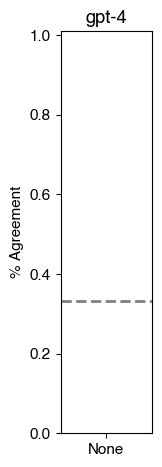

In [42]:
model = 'gpt-4'

dfs = list(random_models_to_dfs_no_agg.values())
dfs = random_models_to_dfs_no_agg[model]
dfs = list(filter(lambda x: x.name == 'None', dfs))

fig, ax = plt.subplots(ncols=1, sharey=True, figsize=(1 + ((3 / 4) * len(dfs)),4.8))
ax.set_xlabel('')

plot_control_binomial(dfs, title=model, ax=ax, blank=True)

save_fig(fig, 'gpt-4_random_control_none_blank')

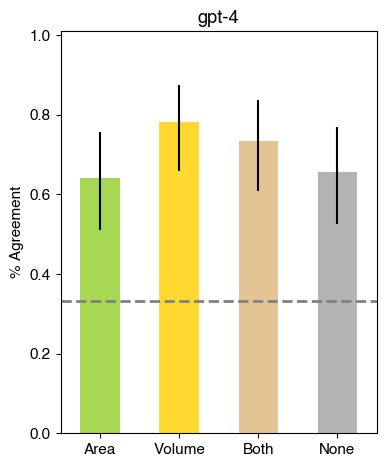

In [43]:
model = 'gpt-4'

dfs = list(random_models_to_dfs_no_agg.values())
dfs = random_models_to_dfs_no_agg[model]

fig, ax = plt.subplots(ncols=1, sharey=True, figsize=(1 + ((3 / 4) * len(dfs)),4.8))

plot_control_binomial(dfs, title=f'{model}', ax=ax)

save_fig(fig, 'gpt-4_random_control')

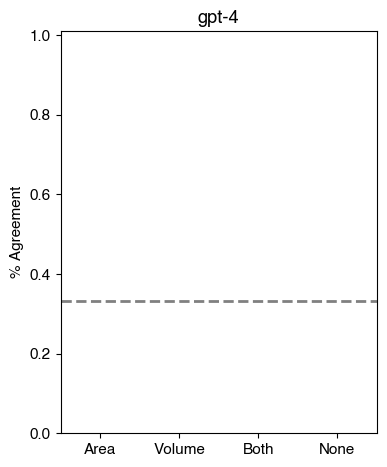

In [44]:
model = 'gpt-4'

dfs = list(random_models_to_dfs_no_agg.values())
dfs = random_models_to_dfs_no_agg[model]

fig, ax = plt.subplots(ncols=1, sharey=True, figsize=(1 + ((3 / 4) * len(dfs)),4.8))

plot_control_binomial(dfs, title=model, ax=ax, blank=True)

save_fig(fig, 'gpt-4_random_control_blank')

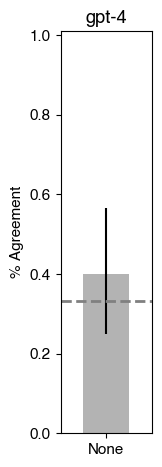

In [45]:
model = 'gpt-4'

dfs = list(models_to_dfs_no_agg.values())
dfs = models_to_dfs_no_agg[model]
dfs = list(filter(lambda x: x.name == 'None', dfs))

fig, ax = plt.subplots(ncols=1, sharey=True, figsize=(1 + ((3 / 4) * len(dfs)),4.8))

plot_control_binomial(dfs, title=model, ax=ax)

save_fig(fig, "gpt-4_control_none")

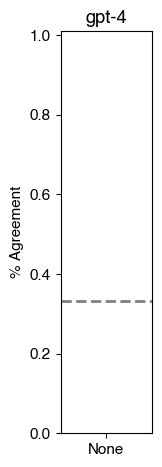

In [46]:
fig, ax = plt.subplots(ncols=1, sharey=True, figsize=(1 + ((3 / 4) * len(dfs)),4.8))

plot_control_binomial(dfs, title=model, ax=ax, blank=True)

save_fig(fig, "gpt-4_control_none_blank")

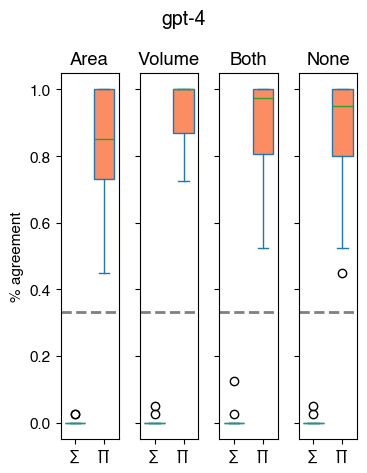

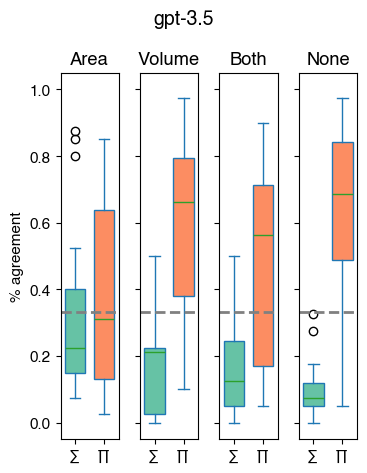

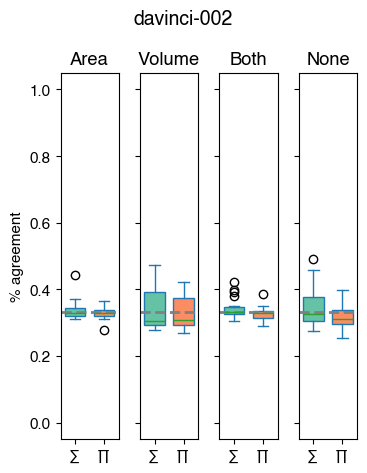

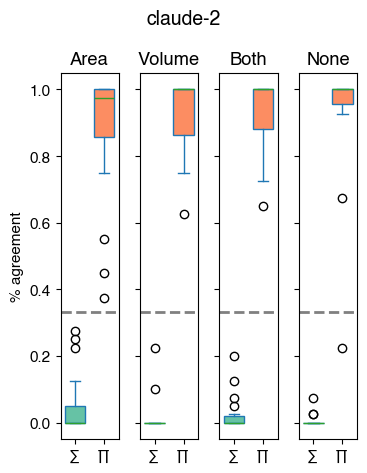

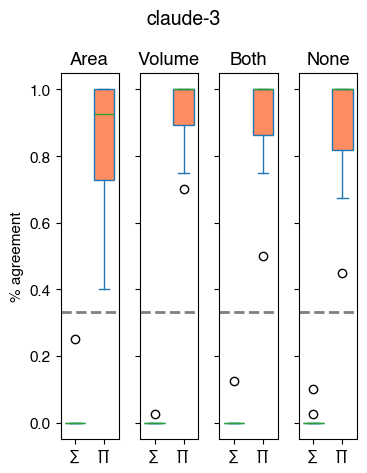

In [47]:
has_axis = [True, True, True, True, True]
for i in range(len(models_to_dfs)):
    model = MODELS[i]
    plot_conditions_distribution(models_to_dfs[model], test, model, axis=has_axis[i])
    plt.tight_layout()
    plt.savefig(f"figures/{model}_test_condition_means.pdf", bbox_inches='tight')
    plt.savefig(f"figures/{model}_test_condition_means.svg", bbox_inches='tight', transparent=True)
    plt.tight_layout()
    plt.show()

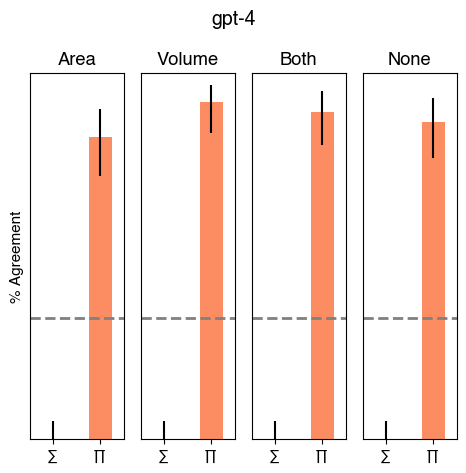

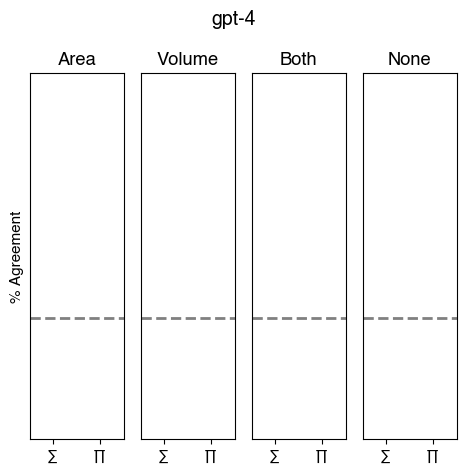

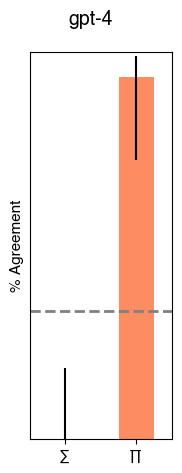

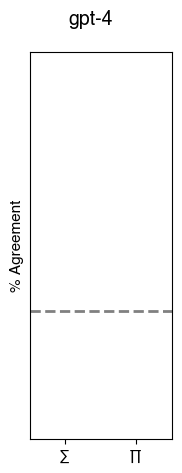

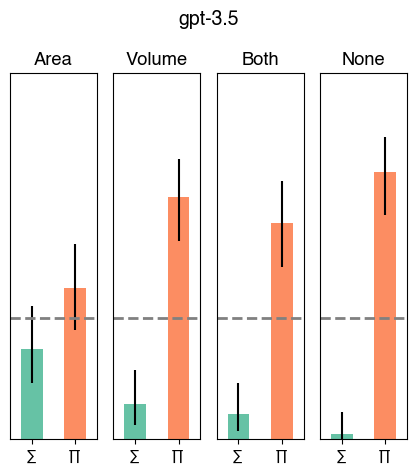

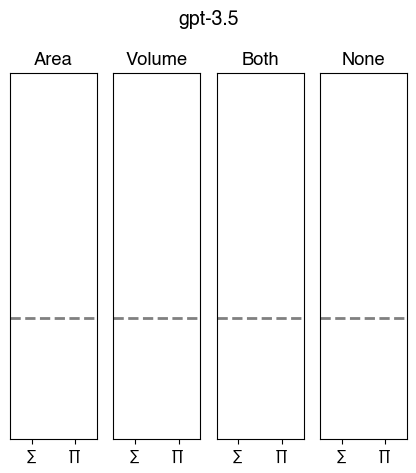

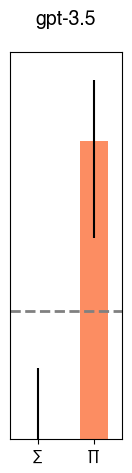

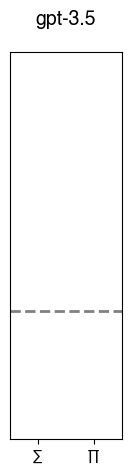

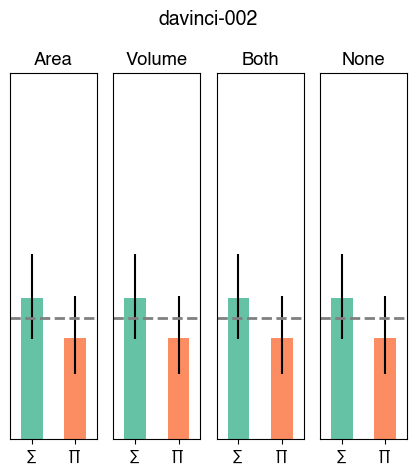

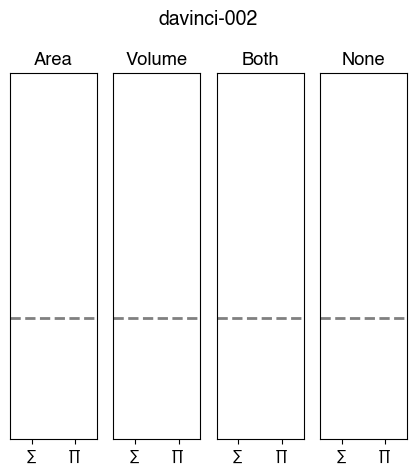

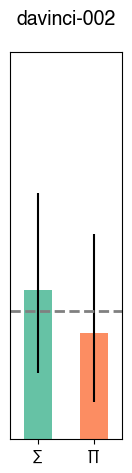

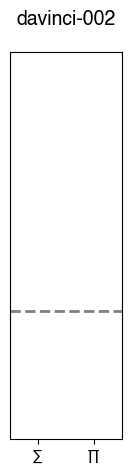

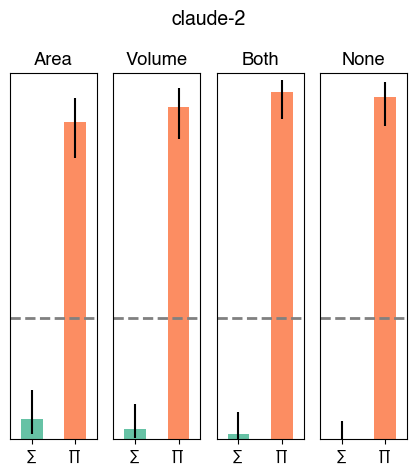

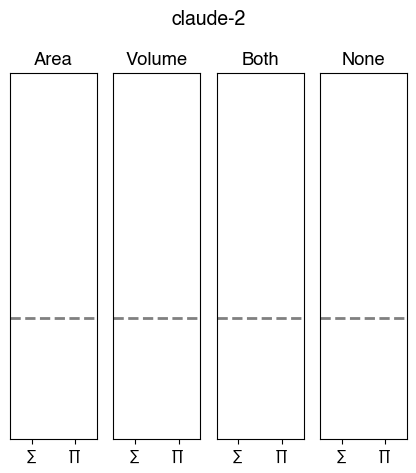

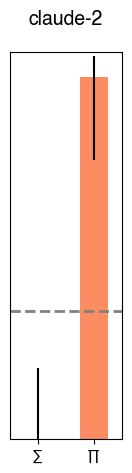

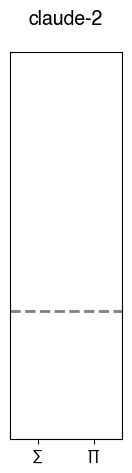

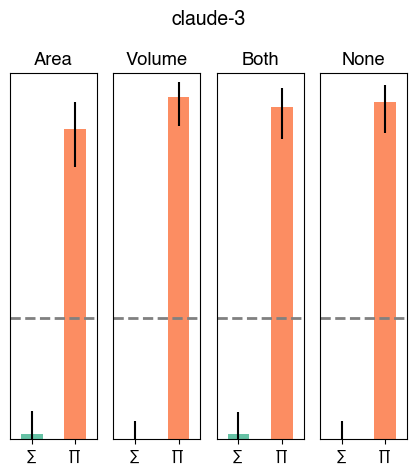

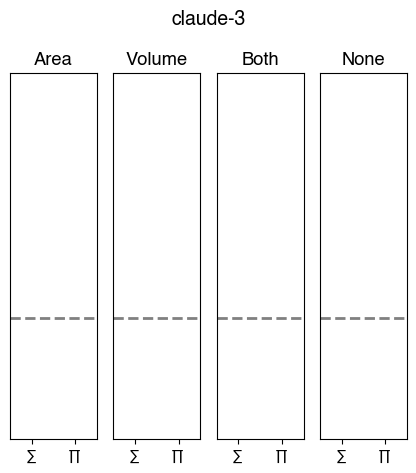

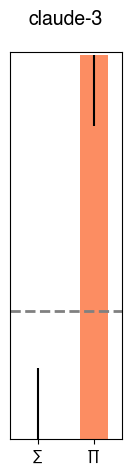

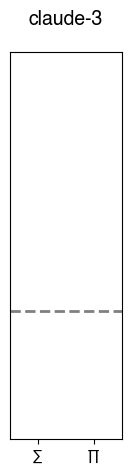

In [48]:
has_axis = [True, False, False, False, False]
for i in range(len(models_to_dfs_no_agg)):
    model = MODELS[i]   
    fig = plot_conditions_binomial(models_to_dfs_no_agg[model], test, model, axis=has_axis[i])
    save_fig(fig, f"{model}_test_condition")

    fig = plot_conditions_binomial(models_to_dfs_no_agg[model], test, model, axis=has_axis[i], blank=True)
    save_fig(fig, f"{model}_test_condition_blank")

    none_only = list(filter(lambda x: x.name == 'None', models_to_dfs[model]))
    if len(none_only) < 1:
        continue

    fig = plot_conditions_binomial(none_only, test, model, axis=has_axis[i])
    for ax in fig.get_axes():
        ax.set_title('')
    save_fig(fig, f"{model}_test_condition_none")

    fig = plot_conditions_binomial(none_only, test, model, axis=has_axis[i], blank=True)
    for ax in fig.get_axes():
        ax.set_title('')
    save_fig(fig, f"{model}_test_condition_none_blank")


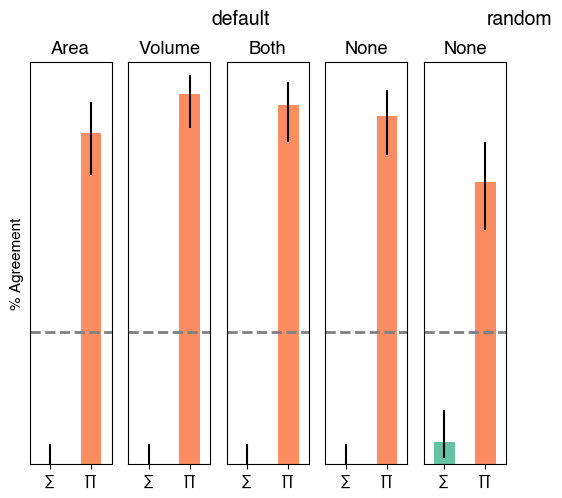

In [49]:
num = 5
fig, axes = plt.subplots(ncols=num, sharey=True, figsize=(1 + LLM_TEST_PLOT_WIDTH * num, 4.8))

model = 'gpt-4'
plot_conditions_binomial(models_to_dfs_no_agg[model], test, 'Focused', axis=True, axes=axes[:-1])


dfs = random_models_to_dfs_no_agg[model]
none_only = list(filter(lambda x: x.name == 'None', dfs))

plot_conditions_binomial(none_only, test, 'Random', axis=False, axes=axes[-1])

space_last_fig_add_titles(fig, axes)

save_fig(fig, f"{model}_test_condition")

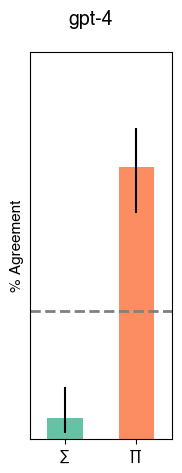

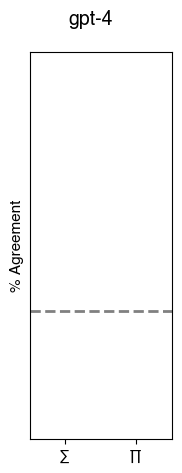

In [50]:
model = 'gpt-4'
dfs = random_models_to_dfs_no_agg[model]
none_only = list(filter(lambda x: x.name == 'None', dfs))

fig = plot_conditions_binomial(none_only, test, f'{model}', axis=True)
for ax in fig.get_axes():
    ax.set_title('')
save_fig(fig, f"{model}_random_test_condition_none")

fig = plot_conditions_binomial(none_only, test, f'{model}', axis=True, blank=True)
for ax in fig.get_axes():
    ax.set_title('')
save_fig(fig, f"{model}_random_test_condition_none_blank")


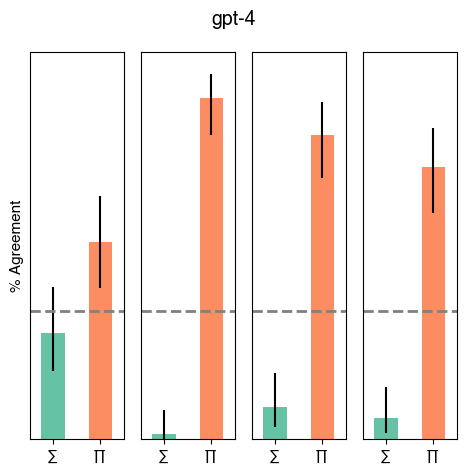

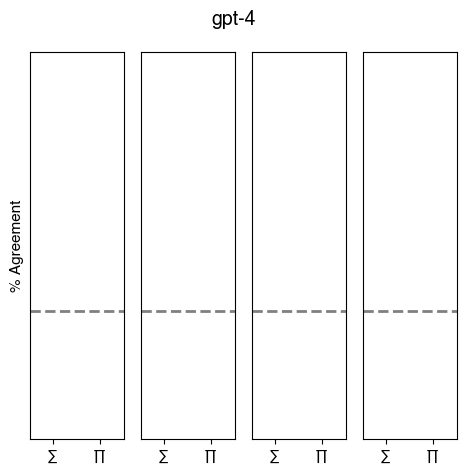

In [51]:
### gpt-4 random scenario check -- share with Sydney!
model = 'gpt-4'

fig = plot_conditions_binomial(random_models_to_dfs_no_agg[model], test,  f'{model}', axis=True)
for ax in fig.get_axes():
    ax.set_title('')
save_fig(fig, f"{model}_random_test_condition")

fig = plot_conditions_binomial(random_models_to_dfs_no_agg[model], test,  f'{model}', axis=True, blank=True)
for ax in fig.get_axes():
    ax.set_title('')
save_fig(fig, f"{model}_random_test_condition_blank")


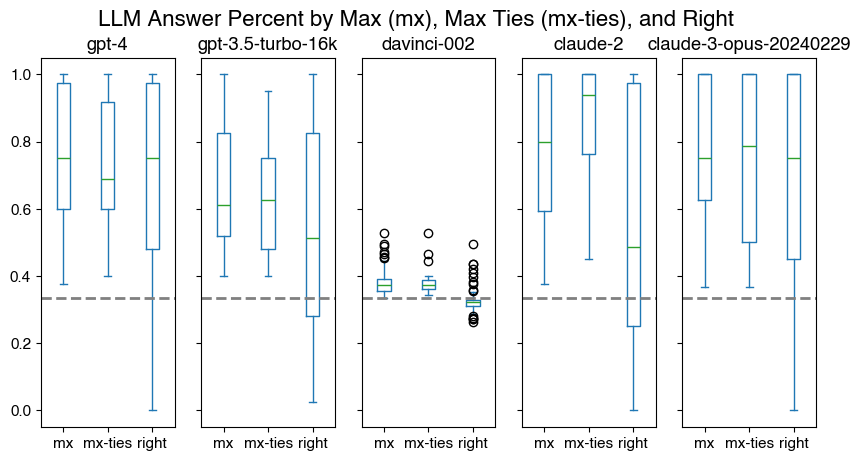

In [52]:
# You would actually expect the probability of the max answer to go down more on the ties!

fig, ax = plt.subplots(ncols=5, sharey=True, figsize=(10, 4.8))
fig.suptitle('LLM Answer Percent by Max (mx), Max Ties (mx-ties), and Right', fontsize=16)

for i in range(len(MODELS_LONG)):
    model = MODELS_LONG[i]
    df = pd.concat(llm_dfs(scenario, desired_model=model))
    df.name = model
    plot_answer_distribution(df, ax=ax[i])
    plot_random(ax[i])

plt.savefig(f"figures/llm_max_ties_right.pdf", bbox_inches='tight')
plt.show()

Area: 0/0.00 failed checks out of 102
Both: 0/0.00 failed checks out of 102
None: 0/0.00 failed checks out of 102
Volume: 0/0.00 failed checks out of 102
Total workers failed checks: 0
total time in minutes: mean 6.1 and std 3.9 and wage $29.4
Area: 0/0.00 failed checks out of 102
Both: 0/0.00 failed checks out of 102
None: 0/0.00 failed checks out of 102
Volume: 0/0.00 failed checks out of 102
Total workers failed checks: 0
total time in minutes: mean 6.1 and std 3.9 and wage $29.4
Area: 0/0.00 failed checks out of 102
Both: 0/0.00 failed checks out of 102
None: 0/0.00 failed checks out of 102
Volume: 0/0.00 failed checks out of 102
Total workers failed checks: 0
total time in minutes: mean 6.1 and std 3.9 and wage $29.4


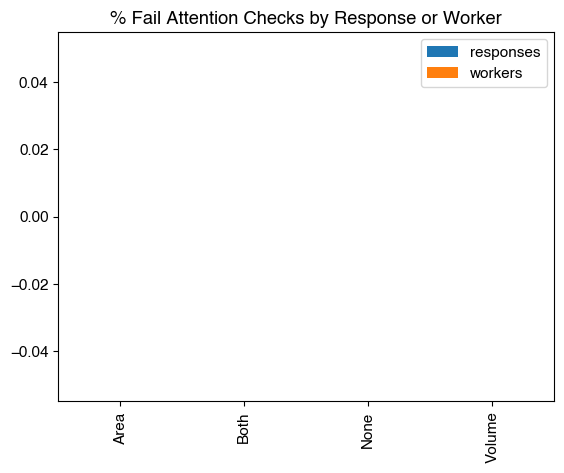

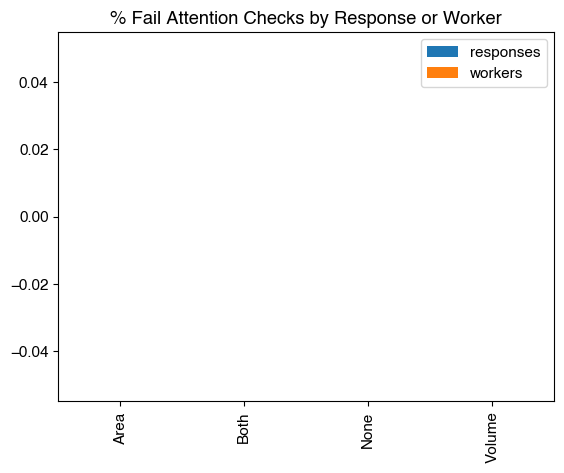

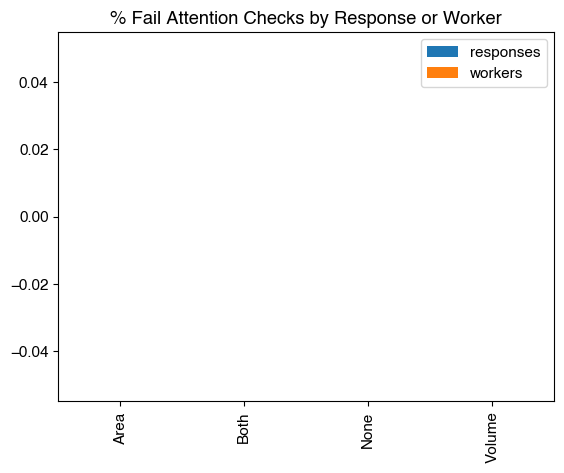

In [53]:
m_dfs = mturk_dfs(scenario, num_scenarios=num_scenarios)
m_dfs_delete_user = mturk_dfs(scenario, num_scenarios=num_scenarios, delete_user_fail_check=True)
m_dfs_filter_control = mturk_dfs(scenario, num_scenarios=num_scenarios, filter_control=True)

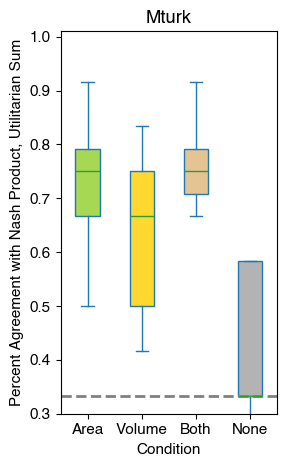

In [54]:
result = []

m_dfs_delete_user = sorted(m_dfs_delete_user, key=lambda x: CONDITION_ORDER.index(x.name))

for df in m_dfs_delete_user:
    right_answer = (control(df)).apply(get_mec_percent, axis=1)
    right_answer.name = df.name
    result.append(right_answer.to_frame())

ax, bplot = pd.concat(result).plot.box(title="Mturk", figsize=(3,4.8), ylim=(.3, 1.01),
                                       ylabel=f"Percent Agreement with {nbs_long}, {mec_long}", xlabel="Condition",
                                       patch_artist=True, return_type='both')
for patch, color in zip(bplot['boxes'], list(CONDITION_TO_COLOR.values())):
    patch.set_facecolor(color)
plot_random(ax)
plt.tight_layout()
plt.savefig(f"figures/mturk_control_means.pdf", bbox_inches='tight')
plt.savefig(f"figures/mturk_control_means.svg", bbox_inches='tight', transparent=True)
plt.show()

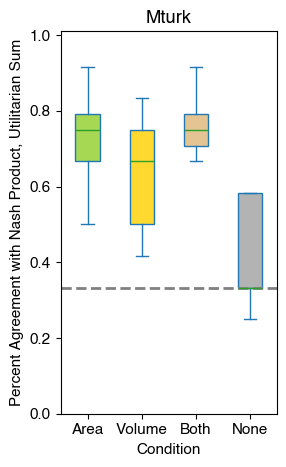

In [55]:
result = []

m_dfs_delete_user = sorted(m_dfs_delete_user, key=lambda x: CONDITION_ORDER.index(x.name))

for df in m_dfs_delete_user:
    right_answer = (control(df)).apply(get_mec_percent, axis=1)
    right_answer.name = df.name
    result.append(right_answer.to_frame())

ax, bplot = pd.concat(result).plot.box(title="Mturk", figsize=(3,4.8), ylim=(0, 1.01),
                                       ylabel=f"Percent Agreement with {nbs_long}, {mec_long}", xlabel="Condition",
                                       patch_artist=True, return_type='both')
for patch, color in zip(bplot['boxes'], list(CONDITION_TO_COLOR.values())):
    patch.set_facecolor(color)
plot_random(ax)
plt.tight_layout()
plt.savefig(f"figures/mturk_control_means_full.pdf", bbox_inches='tight')
plt.savefig(f"figures/mturk_control_means_full.svg", bbox_inches='tight', transparent=True)
plt.show()

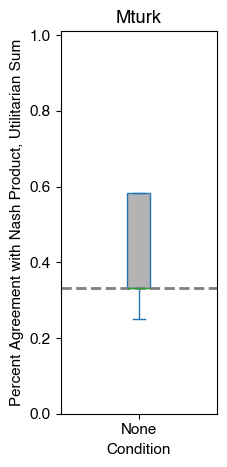

In [56]:
result = []

m_dfs_delete_user = sorted(m_dfs_delete_user, key=lambda x: CONDITION_ORDER.index(x.name))
none_only = list(filter(lambda x: x.name == 'None', m_dfs_delete_user))

for df in none_only:
    right_answer = (control(df)).apply(get_mec_percent, axis=1)
    right_answer.name = df.name
    result.append(right_answer.to_frame())

ax, bplot = pd.concat(result).plot.box(title="Mturk", figsize=(2.4,4.8), ylim=(0, 1.01),
                                       ylabel=f"Percent Agreement with {nbs_long}, {mec_long}", xlabel="Condition",
                                       patch_artist=True, return_type='both')
for patch, color in zip(bplot['boxes'], list(CONDITION_TO_COLOR.values())[3:]):
    patch.set_facecolor(color)
plot_random(ax)
plt.tight_layout()
plt.savefig(f"figures/mturk_control_means_full_none.pdf", bbox_inches='tight')
plt.savefig(f"figures/mturk_control_means_full_none.svg", bbox_inches='tight', transparent=True)
plt.show()

None: 0/0.00 failed checks out of 102
Total workers failed checks: 0
total time in minutes: mean 6.2 and std 5.2 and wage $29.1


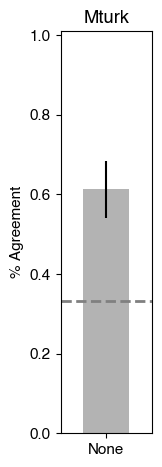

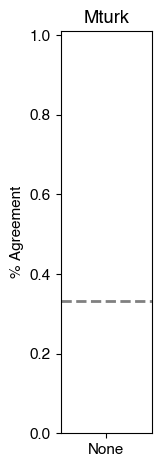

In [57]:
m_random_dfs = mturk_dfs(random_scenario, num_scenarios=num_scenarios, delete_user_fail_check=True,
                   aggregate_responses=False, plot=False)

m_random_dfs = sorted(m_random_dfs, key=lambda x: CONDITION_ORDER.index(x.name))

fig = plot_control_binomial(m_random_dfs, "Mturk")
save_fig(fig, "mturk_random_control")

fig = plot_control_binomial(m_random_dfs, "Mturk", blank=True)
save_fig(fig, "mturk_random_control_blank")

None: 0/0.00 failed checks out of 102
Total workers failed checks: 0
total time in minutes: mean 6.2 and std 5.2 and wage $29.1


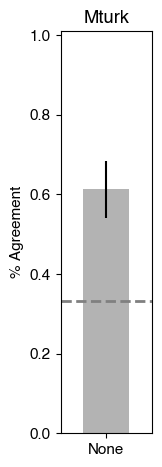

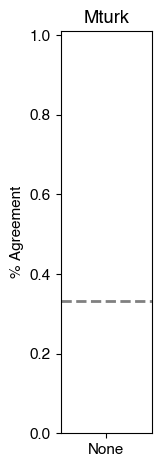

In [58]:
m_random_dfs = mturk_dfs(random_scenario, num_scenarios=num_scenarios, delete_user_fail_check=True,
                   aggregate_responses=False, plot=False)

m_random_dfs = sorted(m_random_dfs, key=lambda x: CONDITION_ORDER.index(x.name))

none_only = list(filter(lambda x: x.name == "None", m_random_dfs))

fig = plot_control_binomial(none_only, "Mturk")
save_fig(fig, "mturk_random_control_none")

fig = plot_control_binomial(none_only, "Mturk", blank=True)
save_fig(fig, "mturk_random_control_none_blank")

Area: 0/0.00 failed checks out of 102
Both: 0/0.00 failed checks out of 102
None: 0/0.00 failed checks out of 102
Volume: 0/0.00 failed checks out of 102
Total workers failed checks: 0
total time in minutes: mean 6.1 and std 3.9 and wage $29.4


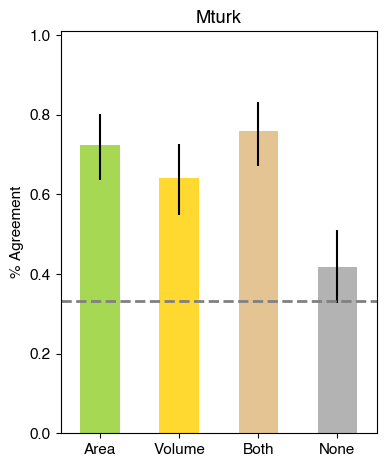

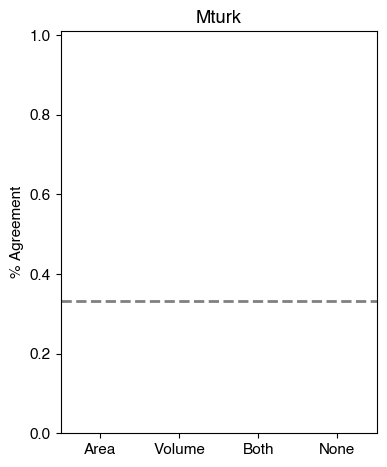

In [59]:
m_dfs2 = mturk_dfs(scenario, num_scenarios=num_scenarios, delete_user_fail_check=True,
                   aggregate_responses=False, plot=False)

m_dfs2 = sorted(m_dfs2, key=lambda x: CONDITION_ORDER.index(x.name))

fig = plot_control_binomial(m_dfs2, "Mturk")
save_fig(fig, "mturk_control")

fig = plot_control_binomial(m_dfs2, "Mturk", blank=True)
save_fig(fig, "mturk_control_blank")

None: 0/0.00 failed checks out of 102
Total workers failed checks: 0
total time in minutes: mean 6.2 and std 5.2 and wage $29.1


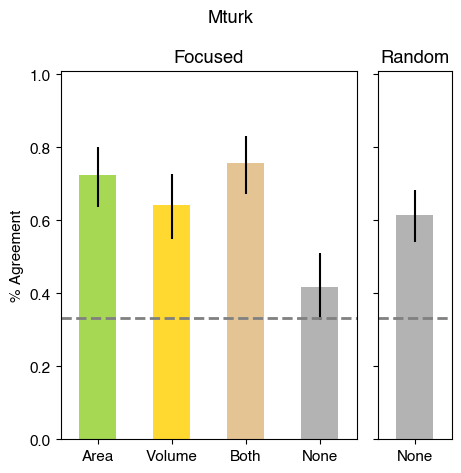

In [60]:


m_dfs2 = sorted(m_dfs2, key=lambda x: CONDITION_ORDER.index(x.name))

num = 5
fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(1 + ((3 / 4) * num),4.8), width_ratios=[4, 1], squeeze=True)

fig.suptitle("Mturk")

plot_control_binomial(m_dfs2, title='Focused', ax=ax[0])

m_random_dfs = mturk_dfs(random_scenario, num_scenarios=num_scenarios, delete_user_fail_check=True,
                   aggregate_responses=False, plot=False)

m_random_dfs = sorted(m_random_dfs, key=lambda x: CONDITION_ORDER.index(x.name))

none_only = list(filter(lambda x: x.name == "None", m_random_dfs))

plot_control_binomial(none_only, title='Random', ax=ax[1])

save_fig(fig, "mturk_control")

None: 0/0.00 failed checks out of 102
Total workers failed checks: 0
total time in minutes: mean 6.2 and std 5.2 and wage $29.1


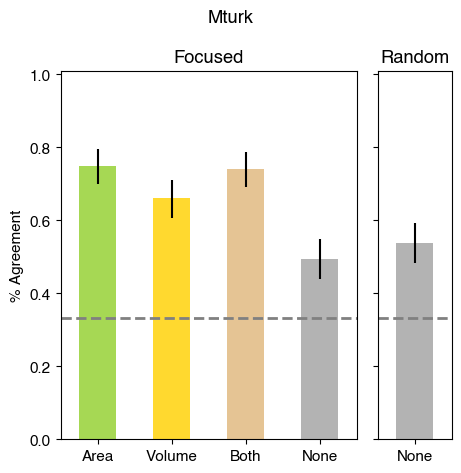

In [61]:
m_dfs2 = sorted(m_dfs2, key=lambda x: CONDITION_ORDER.index(x.name))

num = 5
fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(1 + ((3 / 4) * num),4.8), width_ratios=[4, 1], squeeze=True)

fig.suptitle("Mturk")

plot_control_binomial(m_dfs2, title='Focused', ax=ax[0], between=('scenario_nbs', 'scenario_fehr'))

m_random_dfs = mturk_dfs(random_scenario, num_scenarios=num_scenarios, delete_user_fail_check=True,
                   aggregate_responses=False, plot=False)

m_random_dfs = sorted(m_random_dfs, key=lambda x: CONDITION_ORDER.index(x.name))

none_only = list(filter(lambda x: x.name == "None", m_random_dfs))

plot_control_binomial(none_only, title='Random', ax=ax[1], between=('scenario_nbs', 'scenario_fehr'))

save_fig(fig, "mturk_control_fehr_nash")

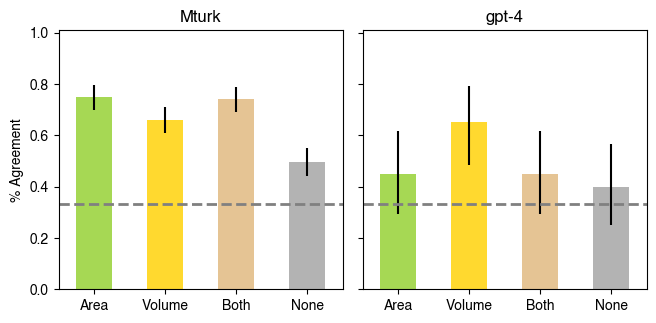

In [62]:
with plt.rc_context({'font.size': 10}):
    
    num = 8
    fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(10 / 1.5, 5 / 1.5), squeeze=True)
    
    plot_control_binomial(m_dfs2, title='Mturk', ax=ax[0], between=('scenario_nbs', 'scenario_fehr'))
    
    model = 'gpt-4'
    
    dfs = list(models_to_dfs_no_agg.values())
    gpt4_dfs = models_to_dfs_no_agg[model]
    
    plot_control_binomial(gpt4_dfs, title=model, ax=ax[1])
    
    save_fig(fig, "mturk_gpt4_control")

Area: 0/0.00 failed checks out of 102
Both: 0/0.00 failed checks out of 102
None: 0/0.00 failed checks out of 102
Volume: 0/0.00 failed checks out of 102
Total workers failed checks: 0
total time in minutes: mean 6.1 and std 3.9 and wage $29.4


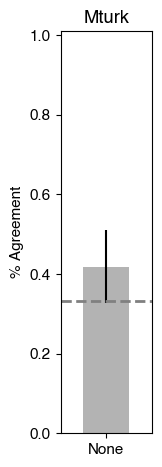

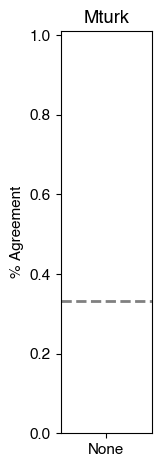

In [63]:
m_dfs2 = mturk_dfs(scenario, num_scenarios=num_scenarios, delete_user_fail_check=True,
                   aggregate_responses=False, plot=False)

m_dfs2 = sorted(m_dfs2, key=lambda x: CONDITION_ORDER.index(x.name))

none_only = list(filter(lambda x: x.name == "None", m_dfs2))

fig = plot_control_binomial(none_only, "Mturk")
save_fig(fig, "mturk_control_none")

fig = plot_control_binomial(none_only, "Mturk", blank=True)
save_fig(fig, "mturk_control_none_blank")

## Do the agreement stats vary by scenario?

In [64]:
from IPython.display import display, HTML

Area: 0/0.00 failed checks out of 102
Both: 0/0.00 failed checks out of 102
None: 0/0.00 failed checks out of 102
Volume: 0/0.00 failed checks out of 102
Total workers failed checks: 0
total time in minutes: mean 6.1 and std 3.9 and wage $29.4


<Figure size 640x480 with 0 Axes>

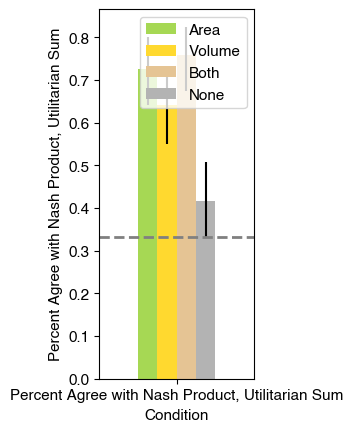

<Figure size 640x480 with 0 Axes>

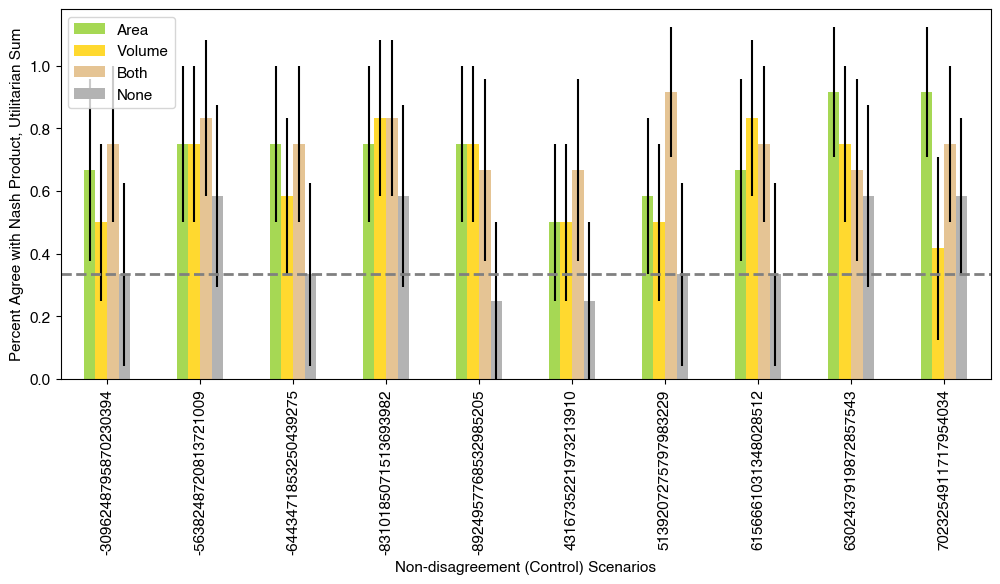

In [65]:


dfs = mturk_dfs(scenario, num_scenarios=num_scenarios, delete_user_fail_check=True, aggregate_responses=False, plot=False)
dfs = sort_by_condition(dfs)

plt.tight_layout()
plot_mean_control_agreement(dfs)
plt.savefig(f"figures/mturk_control_percent_agree.pdf", bbox_inches='tight')
plt.show()

plt.tight_layout()
plot_mean_control_agreement_scenario(dfs)
plt.savefig(f"figures/mturk_control_percent_agree_scenario.pdf", bbox_inches='tight')
plt.show()

In [66]:
np.array((5, 3)).mean()

4.0

<Axes: >

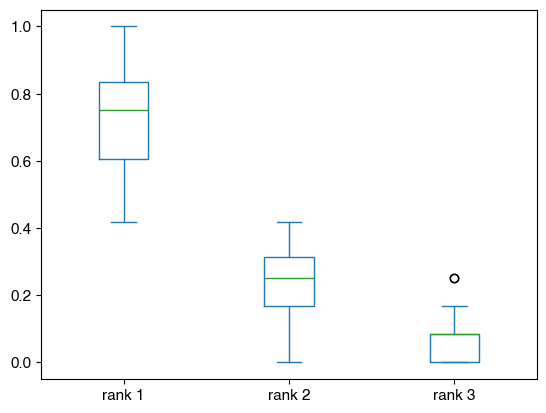

In [67]:
df = m_dfs_delete_user[0]

data = []
for i in range(3):
    series = df.apply(percent_by_position, position=i, axis=1)
    series.name = f'rank {i + 1}'
    data.append(series)

pd.concat(data, axis=1).plot.box()


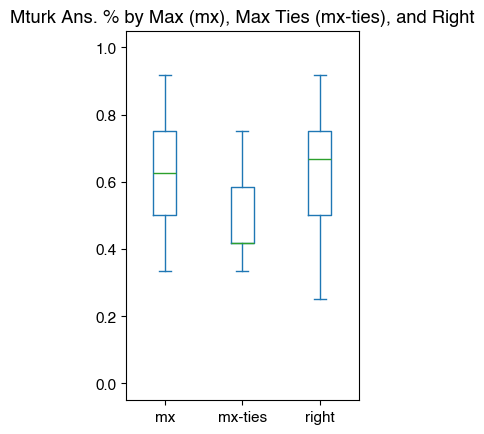

In [68]:
plot_answer_distribution(pd.concat(m_dfs_delete_user), figsize=(3, 4.8), ylim=PERCENT_PLT_YLIM,
                       title="Mturk Ans. % by Max (mx), Max Ties (mx-ties), and Right")
plt.savefig(f"figures/mturk_max_ties_right.pdf", bbox_inches='tight')
plt.show()

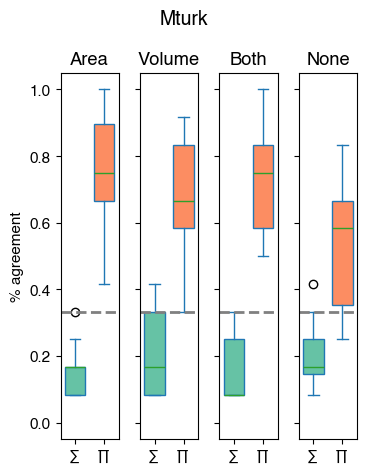

In [69]:
plot_conditions_distribution(m_dfs_delete_user, test, 'Mturk')
plt.tight_layout()
plt.savefig(f"figures/mturk_test_condition_means.pdf", bbox_inches='tight')
plt.savefig(f"figures/mturk_test_condition_means.svg", bbox_inches='tight', transparent=True)
plt.show()

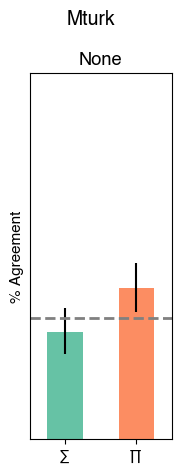

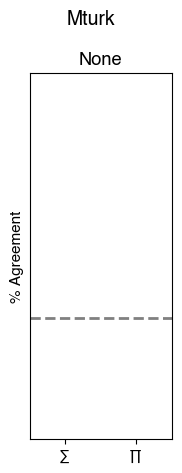

In [70]:
fig = plot_conditions_binomial(dfs = m_random_dfs, selector = test, title = "Mturk")
save_fig(fig, "mturk_random_test_condition")

fig = plot_conditions_binomial(dfs = m_random_dfs, selector = test, title = "Mturk", blank=True)
save_fig(fig, "mturk_random_test_condition_blank")

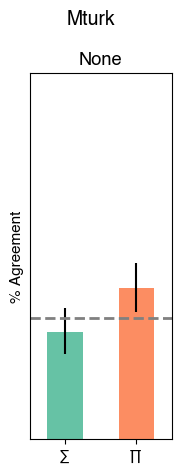

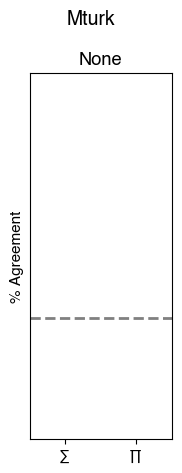

In [71]:
none_only = list(filter(lambda x: x.name == "None", m_random_dfs))

fig = plot_conditions_binomial(dfs = none_only, selector = test, title = "Mturk")
save_fig(fig, "mturk_random_test_condition_none")

fig = plot_conditions_binomial(dfs = none_only, selector = test, title = "Mturk", blank=True)
save_fig(fig, "mturk_random_test_condition_none_blank")


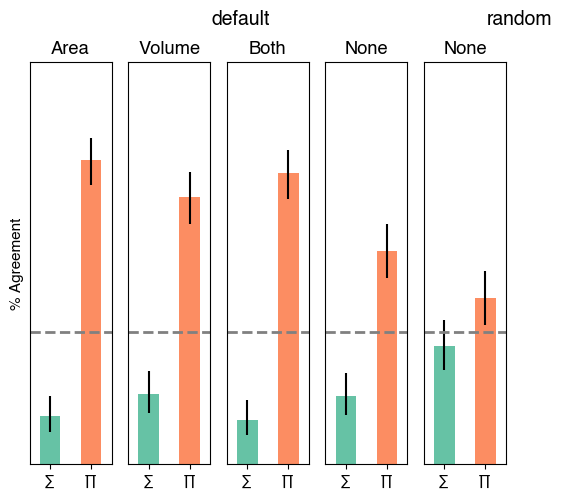

In [72]:

num = 5
fig, axes = plt.subplots(ncols=num, sharey=True, figsize=(1 + LLM_TEST_PLOT_WIDTH * num, 4.8))

plot_conditions_binomial(dfs = m_dfs2, selector = test, title = 'Focused', axes=axes[:-1])


dfs = random_models_to_dfs_no_agg[model]
none_only = list(filter(lambda x: x.name == "None", m_random_dfs))

plot_conditions_binomial(dfs = none_only, selector = test, title = 'Random', axes=axes[-1])

space_last_fig_add_titles(fig, axes)

save_fig(fig, f"mturk_test_condition")


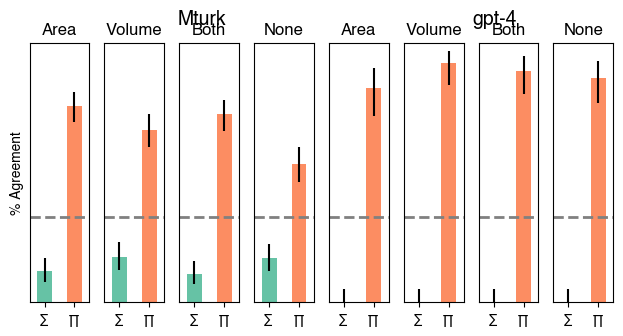

In [73]:
with plt.rc_context({'font.size': 10}):
    num = 8
    fig, axes = plt.subplots(ncols=num, sharey=True, figsize=(10 / 1.5, 5 / 1.5))
    
    plot_conditions_binomial(dfs = m_dfs2, selector = test, title = 'Focused', axes=axes[:4])
    
    model = 'gpt-4'
    plot_conditions_binomial(models_to_dfs_no_agg[model], test, 'Focused', axis=True, axes=axes[4:])
    
    
    extra_space = .05
    for i in range(4, 8):
        pos_last = axes[i].get_position()
        axes[i].set_position([pos_last.x0 + extra_space, pos_last.y0, pos_last.width, pos_last.height])
    
    top_row_suptitle = fig.text(0.31, .95, 'Mturk', ha='center', fontsize=14)
    
    top_row_suptitle = fig.text(.75, .95, 'gpt-4', ha='center', fontsize=14)
    
    save_fig(fig, f"mturk_gpt4_test_condition")


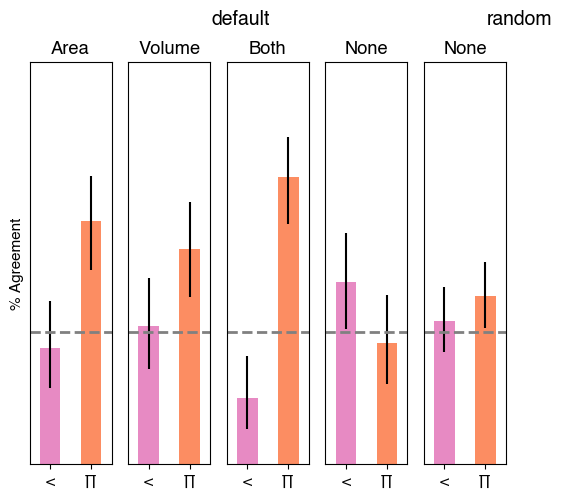

In [74]:

num = 5
fig, axes = plt.subplots(ncols=num, sharey=True, figsize=(1 + LLM_TEST_PLOT_WIDTH * num, 4.8))

plot_conditions_binomial(dfs = m_dfs2, selector = test, title = 'Focused', axes=axes[:-1], between=('scenario_rawls', 'scenario_nbs'))


dfs = random_models_to_dfs_no_agg[model]
none_only = list(filter(lambda x: x.name == "None", m_random_dfs))

plot_conditions_binomial(dfs = none_only, selector = test, title = 'Random', axes=axes[-1], between=('scenario_rawls', 'scenario_nbs'))

space_last_fig_add_titles(fig, axes)

save_fig(fig, f"mturk_test_condition_rawls_nash")


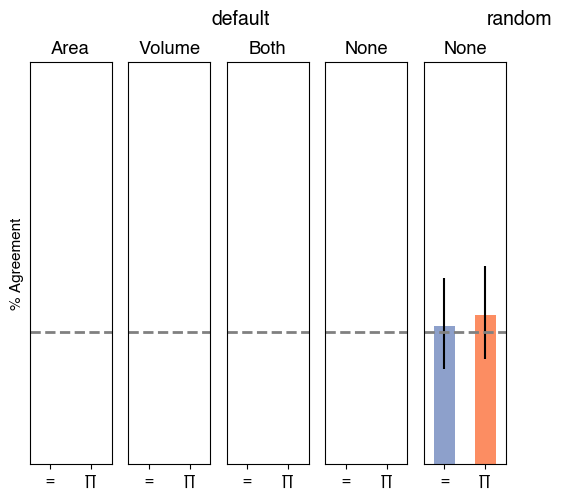

In [75]:

num = 5
fig, axes = plt.subplots(ncols=num, sharey=True, figsize=(1 + LLM_TEST_PLOT_WIDTH * num, 4.8))

plot_conditions_binomial(dfs = m_dfs2, selector = test, title = 'Focused', axes=axes[:-1], between=('scenario_fehr', 'scenario_nbs'))


dfs = random_models_to_dfs_no_agg[model]
none_only = list(filter(lambda x: x.name == "None", m_random_dfs))

plot_conditions_binomial(dfs = none_only, selector = test, title = 'Random', axes=axes[-1], between=('scenario_fehr', 'scenario_nbs'))

space_last_fig_add_titles(fig, axes)

save_fig(fig, f"mturk_test_condition_fehr_nash")


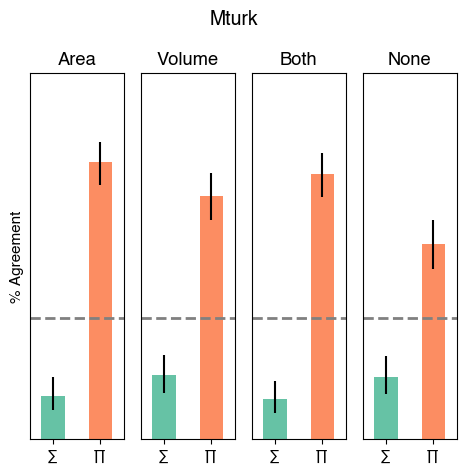

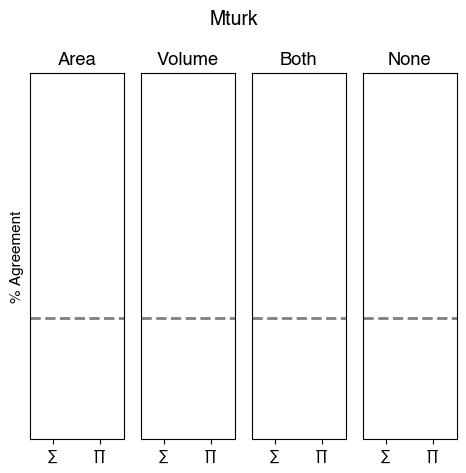

In [76]:
fig = plot_conditions_binomial(dfs = m_dfs2, selector = test, title = "Mturk")
save_fig(fig, "mturk_test_condition")

fig = plot_conditions_binomial(dfs = m_dfs2, selector = test, title = "Mturk", blank=True)
save_fig(fig, "mturk_test_condition_blank")


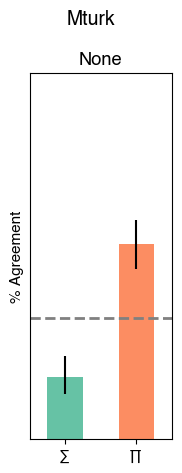

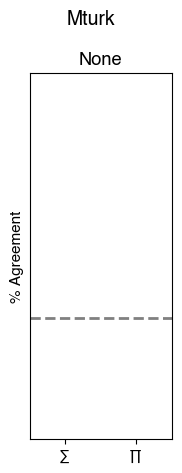

In [77]:
none_only = list(filter(lambda x: x.name == "None", m_dfs2))

fig = plot_conditions_binomial(dfs = none_only, selector = test, title = "Mturk")
save_fig(fig, "mturk_test_condition_none")

fig = plot_conditions_binomial(dfs = none_only, selector = test, title = "Mturk", blank=True)
save_fig(fig, "mturk_test_condition_none_blank")


<Axes: title={'center': 'Mturk % Correct Answer on Control -- filter control'}>

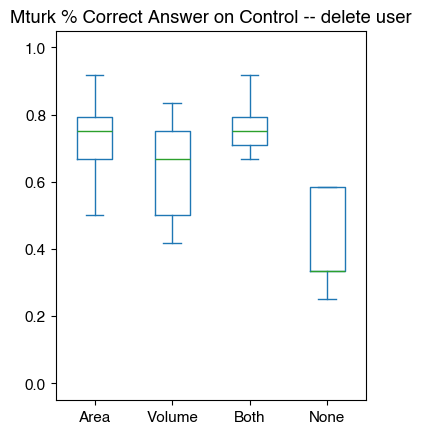

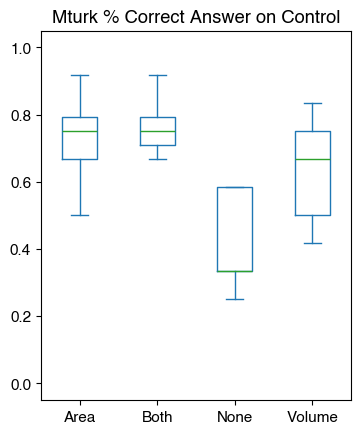

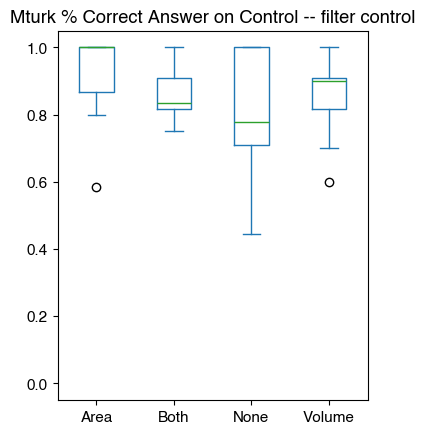

In [78]:
# Despite there being no difference in these, we will remove the entire user

result = []

for df in m_dfs_delete_user:
    right_answer = (control(df)).apply(get_mec_percent, axis=1)
    right_answer.name = df.name
    result.append(right_answer.to_frame())

pd.concat(result).plot.box(title="Mturk % Correct Answer on Control -- delete user", figsize=(4,4.8), ylim=PERCENT_PLT_YLIM)

result = []

for df in m_dfs:
    right_answer = (control(df)).apply(get_mec_percent, axis=1)
    right_answer.name = df.name
    result.append(right_answer.to_frame())

pd.concat(result).plot.box(title="Mturk % Correct Answer on Control", figsize=(4,4.8), ylim=PERCENT_PLT_YLIM)

result = []

for df in m_dfs_filter_control:
    right_answer = (control(df)).apply(get_mec_percent, axis=1)
    right_answer.name = df.name
    result.append(right_answer.to_frame())

pd.concat(result).plot.box(title="Mturk % Correct Answer on Control -- filter control", figsize=(4,4.8), ylim=PERCENT_PLT_YLIM)


<Axes: title={'center': 'Mturk % Correct Answer on Test (Utilitarian Sum answer)'}>

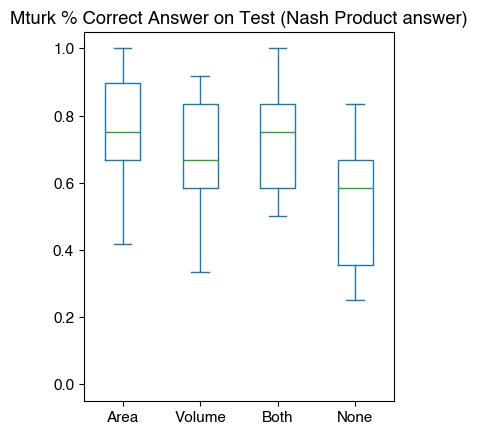

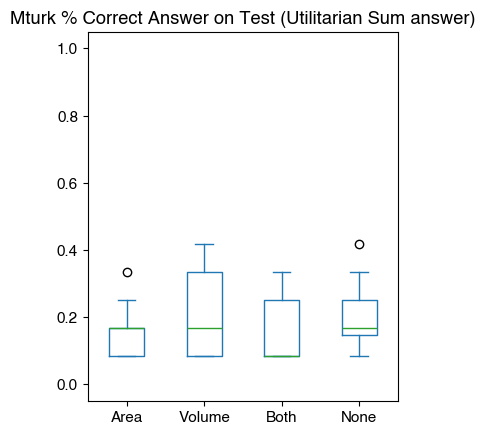

In [79]:
result = []

for df in m_dfs_delete_user:
    right_answer = (test(df)).apply(get_nbs_percent, axis=1)
    right_answer.name = df.name
    result.append(right_answer.to_frame())

pd.concat(result).plot.box(title=f"Mturk % Correct Answer on Test ({nbs_long} answer)", figsize=(4,4.8), ylim=PERCENT_PLT_YLIM)

result = []

for df in m_dfs_delete_user:
    right_answer = (test(df)).apply(get_mec_percent, axis=1)
    right_answer.name = df.name
    result.append(right_answer.to_frame())

pd.concat(result).plot.box(title=f"Mturk % Correct Answer on Test ({mec_long} answer)", figsize=(4,4.8), ylim=PERCENT_PLT_YLIM)

## When there is disagreement which theory gets the most support?

## Stat tests and table construction

In [80]:
m_dfs_unaggregated = mturk_dfs(scenario, num_scenarios=num_scenarios, plot=False, aggregate_responses=False)

Area: 0/0.00 failed checks out of 102
Both: 0/0.00 failed checks out of 102
None: 0/0.00 failed checks out of 102
Volume: 0/0.00 failed checks out of 102
Total workers failed checks: 0
total time in minutes: mean 6.1 and std 3.9 and wage $29.4


In [81]:
stat_tests_and_means_counts_control(sorted(m_dfs_unaggregated, key=lambda x: CONDITION_ORDER.index(x.name)))

\begin{tabular}{lllll}
\toprule
 & Area & Volume & Both & None \\
\midrule
∑&∏ & 87 / 120*** & 77 / 120*** & 91 / 120*** & 50 / 120 \\
\bottomrule
\end{tabular}



In [82]:
stat_tests_and_means_counts_test(sorted(m_dfs_unaggregated, key=lambda x: CONDITION_ORDER.index(x.name)))

\begin{tabular}{lllll}
\toprule
 & Area & Volume & Both & None \\
\midrule
Nash Product & 165 / 216*** & 145 / 216*** & 158 / 216*** & 116 / 216*** \\
Utilitarian Sum & 26 / 216*** & 38 / 216*** & 24 / 216*** & 37 / 216*** \\
\bottomrule
\end{tabular}



In [83]:
dfs = llm_dfs(scenario, desired_model='gpt-4', qualification=False, aggregate_responses=False)

In [84]:
# mturk
# llms

for model in MODEL_NAMES_SHORT.keys():
    print(MODEL_NAMES_SHORT[model])
    dfs = sorted(llm_dfs(scenario, desired_model=model, qualification=False, aggregate_responses=False),
                 key=lambda x: CONDITION_ORDER.index(x.name))
    stat_tests_and_means_counts_test(dfs)
    stat_tests_and_means_counts_control(dfs)

gpt-4
\begin{tabular}{lllll}
\toprule
 & Area & Volume & Both & None \\
\midrule
Nash Product & 60 / 72*** & 67 / 72*** & 65 / 72*** & 63 / 72*** \\
Utilitarian Sum & 0 / 72*** & 0 / 72*** & 0 / 72*** & 0 / 72*** \\
\bottomrule
\end{tabular}

\begin{tabular}{lllll}
\toprule
 & Area & Volume & Both & None \\
\midrule
∑&∏ & 18 / 40 & 26 / 40*** & 18 / 40 & 16 / 40 \\
\bottomrule
\end{tabular}

gpt-3.5
\begin{tabular}{lllll}
\toprule
 & Area & Volume & Both & None \\
\midrule
Nash Product & 30 / 72 & 48 / 72*** & 43 / 72*** & 53 / 72*** \\
Utilitarian Sum & 18 / 72 & 7 / 72*** & 5 / 72*** & 1 / 72*** \\
\bottomrule
\end{tabular}

\begin{tabular}{lllll}
\toprule
 & Area & Volume & Both & None \\
\midrule
∑&∏ & 11 / 40 & 23 / 40** & 17 / 40 & 12 / 40 \\
\bottomrule
\end{tabular}

davinci-002
\begin{tabular}{lllll}
\toprule
 & Area & Volume & Both & None \\
\midrule
Nash Product & 20 / 72 & 20 / 72 & 20 / 72 & 20 / 72 \\
Utilitarian Sum & 28 / 72 & 28 / 72 & 28 / 72 & 28 / 72 \\
\bottomrule


## random scenarios

In [85]:
m_dfs_unaggregated = mturk_dfs(random_scenario, num_scenarios=num_scenarios, plot=False, aggregate_responses=False)

None: 0/0.00 failed checks out of 102
Total workers failed checks: 0
total time in minutes: mean 6.2 and std 5.2 and wage $29.1


In [86]:
stat_tests_and_means_counts_control(sorted(m_dfs_unaggregated, key=lambda x: CONDITION_ORDER.index(x.name)))

\begin{tabular}{ll}
\toprule
 & None \\
\midrule
∑&∏ & 118 / 192*** \\
\bottomrule
\end{tabular}



In [87]:
stat_tests_and_means_counts_test(sorted(m_dfs_unaggregated, key=lambda x: CONDITION_ORDER.index(x.name)))

\begin{tabular}{ll}
\toprule
 & None \\
\midrule
Nash Product & 90 / 216* \\
Utilitarian Sum & 64 / 216 \\
\bottomrule
\end{tabular}



In [88]:
# mturk
# llms

for model in MODEL_NAMES_SHORT.keys():
    print(MODEL_NAMES_SHORT[model])
    dfs = sorted(llm_dfs(random_scenario, desired_model=model, qualification=False, aggregate_responses=False),
                 key=lambda x: CONDITION_ORDER.index(x.name))
    stat_tests_and_means_counts_test(dfs)
    stat_tests_and_means_counts_control(dfs)

gpt-4
\begin{tabular}{lllll}
\toprule
 & Area & Volume & Both & None \\
\midrule
Nash Product & 37 / 72** & 64 / 72*** & 57 / 72*** & 51 / 72*** \\
Utilitarian Sum & 20 / 72 & 1 / 72*** & 6 / 72*** & 4 / 72*** \\
\bottomrule
\end{tabular}

\begin{tabular}{lllll}
\toprule
 & Area & Volume & Both & None \\
\midrule
∑&∏ & 41 / 64*** & 50 / 64*** & 47 / 64*** & 42 / 64*** \\
\bottomrule
\end{tabular}

gpt-3.5
\begin{tabular}{lllll}
\toprule
 & Area & Volume & Both & None \\
\midrule
Nash Product & 29 / 72 & 46 / 72*** & 36 / 72** & 34 / 72* \\
Utilitarian Sum & 20 / 72 & 14 / 72* & 20 / 72 & 10 / 72*** \\
\bottomrule
\end{tabular}

\begin{tabular}{lllll}
\toprule
 & Area & Volume & Both & None \\
\midrule
∑&∏ & 26 / 64 & 40 / 64*** & 29 / 64* & 15 / 64 \\
\bottomrule
\end{tabular}

davinci-002
\begin{tabular}{lllll}
\toprule
 & Area & Volume & Both & None \\
\midrule
Nash Product & 24 / 72 & 24 / 72 & 24 / 72 & 24 / 72 \\
Utilitarian Sum & 24 / 72 & 24 / 72 & 24 / 72 & 24 / 72 \\
\bottomru